In [1]:
from sklearn.cluster import AgglomerativeClustering
import hdbscan
import pickle
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from string import punctuation
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from time import time
from sklearn.metrics.cluster import contingency_matrix
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import homogeneity_score, v_measure_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score,silhouette_score
from sklearn.decomposition import NMF
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
import numpy as np
from plotmat import plot_mat # using the provided plotmat.py from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

In [2]:

stop_words_skt = text.ENGLISH_STOP_WORDS

#nltk.download('stopwords' )
stop_words_en = stopwords.words('english')

print("# of stop_words_skt:\t\t %s" % len(stop_words_skt))
print("# of stop_words_en:\t\t %s" % len(stop_words_en))

print("# of punctuation:\t\t %s" % len(punctuation))
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
print("# of combined_stopwords:\t %s" % len(combined_stopwords))

# of stop_words_skt:		 318
# of stop_words_en:		 179
# of punctuation:		 32
# of combined_stopwords:	 410


In [3]:
class1 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
class2 = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
categories = class1+class2
contain_class1 = set(class1)
contain_class2 = set(class2)

In [4]:
data_train = fetch_20newsgroups(subset="all",categories=categories,
    random_state=42,
    remove=("headers", "footers"))

In [5]:
df_data = pd.DataFrame({"content":data_train.data,"label":data_train.target})

In [6]:
df_data

content  label
0     thought I'd post this as well as e-mail it, ju...      2
1     I have been experiencing several end-user prob...      1
2     In article <pdb059-210493145738@kilimanjaro.jp...      2
3     Could someone please do one of the following:\...      3
4     Your list of Jewish ballplayers includes Levi ...      6
...                                                 ...    ...
7877  In a recent article rcaldrn@med.miami.edu (Ric...      1
7878  In article <1993Apr20.004746.13007@ramsey.cs.l...      6
7879  Rithea Hong (r0h7630@tamuts.tamu.edu) wrote:\n...      2
7880  In article <1r9bi6$s2b@apple.com> opstad@apple...      3
7881  I have a 90 Eagle Talon and I wanted a pair of...      4

[7882 rows x 2 columns]

In [7]:
lab1 = 0
lab2 = 0
for x in df_data["label"]:
    if x <=3:
        lab1+=1
    else:
        lab2+=1
print(lab1,lab2)

3903 3979


In [8]:
vectorizer = CountVectorizer(min_df=3,stop_words = 'english')
pipe = Pipeline([('count', vectorizer),('tfid', TfidfTransformer())])

In [9]:
data_transformed = pipe.fit_transform(df_data["content"])

# Q1

In [10]:
data_transformed.shape

(7882, 23522)

# Q2

In [11]:
labels = [ 1 if x <=3 else 2 for x in df_data['label']]
evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [12]:
kmeans = KMeans(
        n_clusters=2,
        max_iter=1100,
        n_init=40,
        random_state=0,
)
kmeans.fit(data_transformed)

KMeans(max_iter=1100, n_clusters=2, n_init=40, random_state=0)

In [13]:
kmeans.labels_

array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

In [14]:
contingency_matrix(labels,kmeans.labels_)

array([[3155,  748],
       [  53, 3926]])

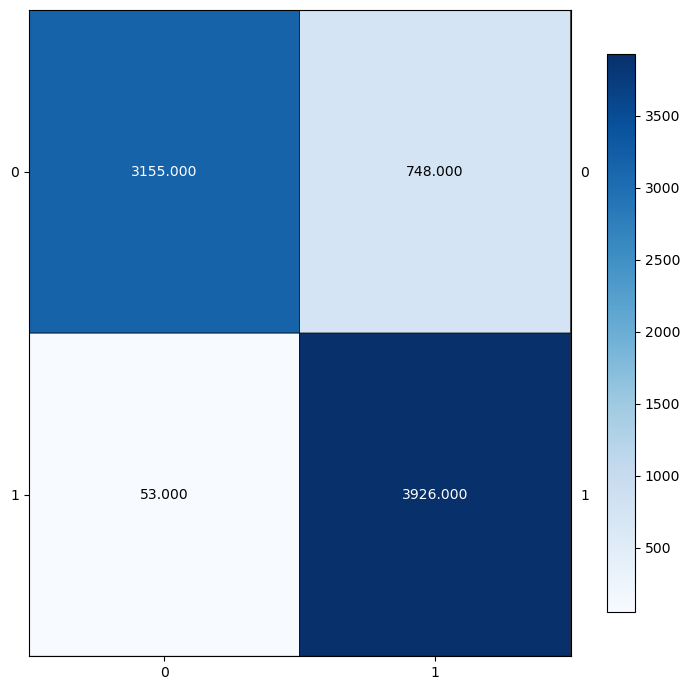

In [15]:
plot_mat(contingency_matrix(labels,kmeans.labels_),size=(7,7))

# Q3

In [16]:
print("Homogeneity: ", homogeneity_score(labels,kmeans.labels_))
print("Completeness: ",completeness_score(labels,kmeans.labels_))
print("V-measure: ",v_measure_score(labels,kmeans.labels_))
print("Adjusted Rand Index: ",adjusted_rand_score(labels,kmeans.labels_))
print("Adjusted mutual information score: ",adjusted_mutual_info_score(labels,kmeans.labels_))

Homogeneity:  0.5743550092788849
Completeness:  0.5891028962710695
V-measure:  0.5816354813353589
Adjusted Rand Index:  0.6347679876064505
Adjusted mutual information score:  0.5815966940443421


# Q4

In [17]:
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
svd.fit(data_transformed)


TruncatedSVD(n_components=1000, n_iter=7, random_state=42)

In [18]:
from sklearn.preprocessing import StandardScaler


model = TruncatedSVD(n_components=1000, algorithm = 'randomized', n_iter=7, random_state=42)
model.fit_transform(data_transformed)

array([[ 0.13202992,  0.0013572 , -0.01187849, ...,  0.01784048,
        -0.00238382,  0.0137484 ],
       [ 0.13071614, -0.05379625, -0.05736558, ...,  0.01241411,
        -0.01490916, -0.01633566],
       [ 0.1574049 , -0.12033844,  0.1196939 , ...,  0.00650918,
         0.00837011,  0.00774894],
       ...,
       [ 0.07522627,  0.01059875, -0.01102102, ...,  0.01133393,
         0.00294935,  0.0396763 ],
       [ 0.15158911,  0.01446036, -0.00536385, ..., -0.01087907,
        -0.00105909,  0.0064974 ],
       [ 0.06821521,  0.01989866,  0.01911755, ..., -0.03359514,
         0.00826496,  0.01870149]])

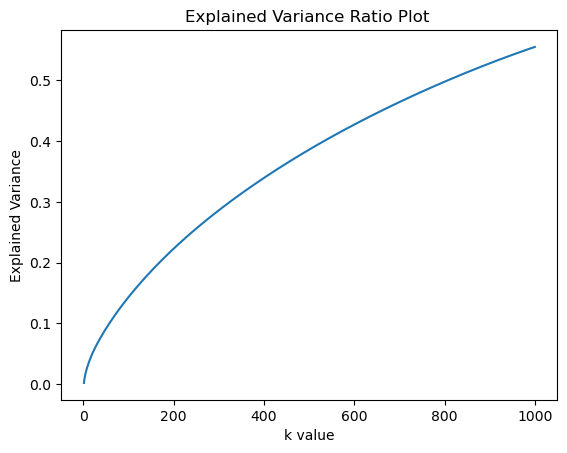

In [19]:
explained = np.cumsum(model.explained_variance_ratio_)
plt.plot(range(1,1001), explained)
plt.title("Explained Variance Ratio Plot ")
plt.xlabel('k value')
plt.ylabel('Explained Variance')
plt.show()

# Q5

In [20]:
r = [1,2,3,4,5,6,7,8,9,10,20,50,100,300]
lab_collections = []
for x in tqdm(range(len(r))):
    model = TruncatedSVD(n_components=r[x], algorithm = 'randomized', n_iter=7, random_state=42)
    matri = model.fit_transform(data_transformed)
    kmeans.fit(matri)
    lab_collections.append(kmeans.labels_)



100%|███████████████████████████████████████████| 14/14 [00:22<00:00,  1.57s/it]


In [21]:
hom = []
com = []
v_mea = []
adj_r = []
adj_mu = []
for x in range(len(r)):
    hom.append(homogeneity_score(labels,lab_collections[x]))
    com.append(completeness_score(labels,lab_collections[x]))
    v_mea.append(v_measure_score(labels,lab_collections[x]))
    adj_r.append(adjusted_rand_score(labels,lab_collections[x]))
    adj_mu.append(adjusted_mutual_info_score(labels,lab_collections[x]))
    print("Homogeneity: ", homogeneity_score(labels,lab_collections[x]))
    print("Completeness: ",completeness_score(labels,lab_collections[x]))
    print("V-measure: ",v_measure_score(labels,lab_collections[x]))
    print("Adjusted Rand Index: ",adjusted_rand_score(labels,lab_collections[x]))
    print("Adjusted mutual information score: ",adjusted_mutual_info_score(labels,lab_collections[x]))
    print("")

Homogeneity:  0.018956544515354657
Completeness:  0.019260434831635448
V-measure:  0.01910728144974337
Adjusted Rand Index:  0.025920756456215145
Adjusted mutual information score:  0.019016765796732785

Homogeneity:  0.5293668070776788
Completeness:  0.5469191458975473
V-measure:  0.5379998525356577
Adjusted Rand Index:  0.585613765957188
Adjusted mutual information score:  0.5379568659463579

Homogeneity:  0.5377651779879102
Completeness:  0.5542779518154466
V-measure:  0.5458967201533174
Adjusted Rand Index:  0.5965400007596544
Adjusted mutual information score:  0.54585451772463

Homogeneity:  0.5019012283472266
Completeness:  0.5273887102939498
V-measure:  0.5143294062748432
Adjusted Rand Index:  0.5362076073368977
Adjusted mutual information score:  0.5142838410628868

Homogeneity:  0.5167393047588145
Completeness:  0.5395444214268553
V-measure:  0.5278956823871446
Adjusted Rand Index:  0.5576023794674495
Adjusted mutual information score:  0.5278515271809274

Homogeneity:  0.524

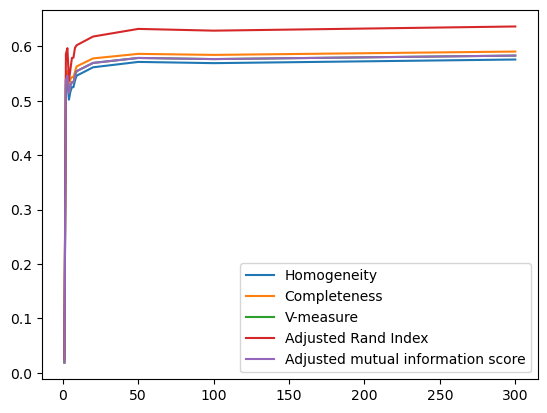

In [22]:
plt.plot(r, hom, label = "Homogeneity")
plt.plot(r, com, label = "Completeness")
plt.plot(r, v_mea, label = "V-measure")
plt.plot(r, adj_r, label = "Adjusted Rand Index")
plt.plot(r, adj_mu, label = "Adjusted mutual information score")
plt.legend()
plt.show()

In [23]:
lab_collections2 = []
for x in tqdm(range(len(r))):
    NMF_1 = NMF(n_components=r[x], init='random', random_state=42,max_iter=1000)
    W = NMF_1.fit_transform(data_transformed)
    kmeans.fit(W)
    lab_collections2.append(kmeans.labels_)



100%|███████████████████████████████████████████| 14/14 [14:49<00:00, 63.51s/it]


In [24]:
hom2 = []
com2 = []
v_mea2 = []
adj_r2 = []
adj_mu2 = []
for x in range(len(r)):
    hom2.append(homogeneity_score(labels,lab_collections2[x]))
    com2.append(completeness_score(labels,lab_collections2[x]))
    v_mea2.append(v_measure_score(labels,lab_collections2[x]))
    adj_r2.append(adjusted_rand_score(labels,lab_collections2[x]))
    adj_mu2.append(adjusted_mutual_info_score(labels,lab_collections2[x]))
    print("Homogeneity: ", homogeneity_score(labels,lab_collections2[x]))
    print("Completeness: ",completeness_score(labels,lab_collections2[x]))
    print("V-measure: ",v_measure_score(labels,lab_collections2[x]))
    print("Adjusted Rand Index: ",adjusted_rand_score(labels,lab_collections2[x]))
    print("Adjusted mutual information score: ",adjusted_mutual_info_score(labels,lab_collections2[x]))
    print("")

Homogeneity:  0.018956544515354657
Completeness:  0.019260434831635448
V-measure:  0.01910728144974337
Adjusted Rand Index:  0.025920756456215145
Adjusted mutual information score:  0.019016765796732785

Homogeneity:  0.49436629542018734
Completeness:  0.5201076638663424
V-measure:  0.5069103975543827
Adjusted Rand Index:  0.5287998174841438
Adjusted mutual information score:  0.5068641086497574

Homogeneity:  0.19951876419783976
Completeness:  0.2947765044994327
V-measure:  0.23796887252143872
Adjusted Rand Index:  0.11951375550462902
Adjusted mutual information score:  0.23788564744176852

Homogeneity:  0.04692504995474571
Completeness:  0.16542651155887647
V-measure:  0.07311128077804721
Adjusted Rand Index:  0.011097673265433138
Adjusted mutual information score:  0.0729789174470931

Homogeneity:  0.040791321221174695
Completeness:  0.1539550035833579
V-measure:  0.06449444436067417
Adjusted Rand Index:  0.00915047637987103
Adjusted mutual information score:  0.06435885802704695

H

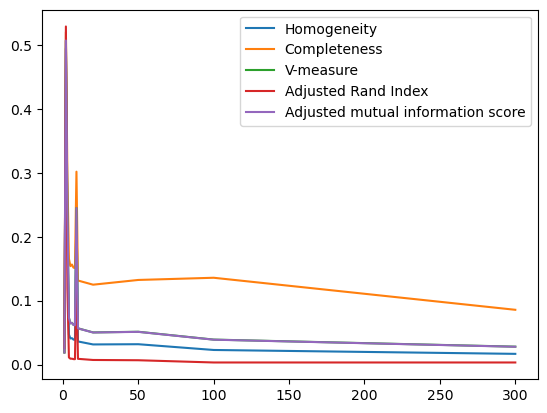

In [25]:
plt.plot(r, hom2, label = "Homogeneity")
plt.plot(r, com2, label = "Completeness")
plt.plot(r, v_mea2, label = "V-measure")
plt.plot(r, adj_r2, label = "Adjusted Rand Index")
plt.plot(r, adj_mu2, label = "Adjusted mutual information score")
plt.legend()
plt.show()

# Q8

In [26]:
best_pac = TruncatedSVD(n_components=300, algorithm = 'randomized', n_iter=7, random_state=42)
best_NMF = NMF(n_components=2, init='random', random_state=42,max_iter=1000)

In [27]:
best_pac_matrix = best_pac.fit_transform(data_transformed)
best_NMF_matrix = best_NMF.fit_transform(data_transformed)

In [28]:
kmeans = KMeans(
        n_clusters=2,
        max_iter=1100,
        n_init=40,
        random_state=0,
)

kmeans2 = KMeans(
        n_clusters=2,
        max_iter=1100,
        n_init=40,
        random_state=0,
)

kmeans.fit(best_pac_matrix)
kmeans2.fit(best_pac_matrix)

KMeans(max_iter=1100, n_clusters=2, n_init=40, random_state=0)

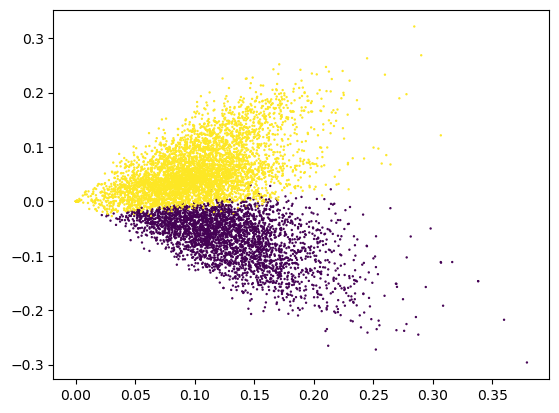

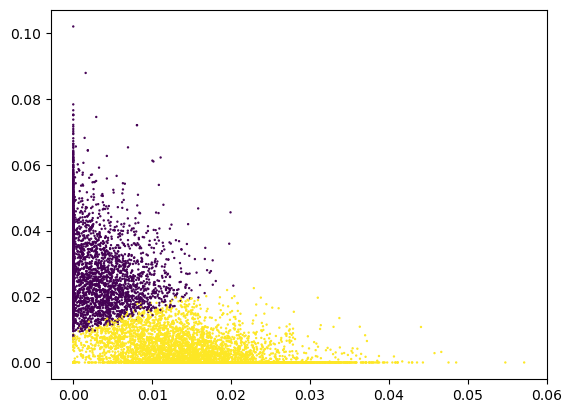

In [29]:
plt.scatter(best_pac_matrix[:,0] , best_pac_matrix[:,1] ,c = kmeans.labels_,s=0.5)
plt.show()
plt.scatter(best_NMF_matrix[:,0] , best_NMF_matrix[:,1] ,c = kmeans2.labels_,s=0.5)
plt.show()

In [30]:
labelss = []
for x in df_data["label"]:
    if x <=3:
        labelss.append(1)
    else:
        labelss.append(2)
print(lab1,lab2)

3903 3979


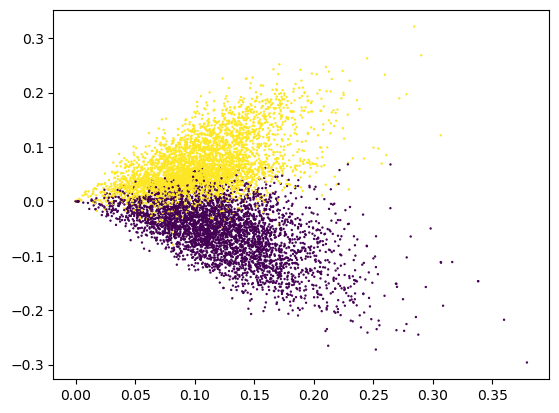

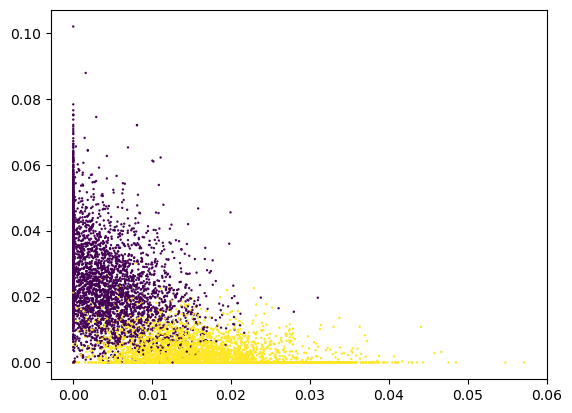

In [31]:
plt.scatter(best_pac_matrix[:,0] , best_pac_matrix[:,1] ,c = labelss,s=0.5)
plt.show()
plt.scatter(best_NMF_matrix[:,0] , best_NMF_matrix[:,1] ,c = labelss,s=0.5)
plt.show()

# Q10

In [32]:
data_train_20 = fetch_20newsgroups(subset="all",
    random_state=42,
    remove=("headers", "footers"))

In [33]:
df_data_20 = pd.DataFrame({"content":data_train_20.data,"label":data_train_20.target})

In [34]:
df_data_20

content  label
0      \n\nI am sure some bashers of Pens fans are pr...     10
1      My brother is in the market for a high-perform...      3
2      |>The student of "regional killings" alias Dav...     17
3      In article <1993Apr19.034517.12820@julian.uwo....      3
4      1)    I have an old Jasmine drive which I cann...      4
...                                                  ...    ...
18841  DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...     13
18842  In article <1993Apr22.004728.6736@mtu.edu> cmw...     12
18843  I just installed a DX2-66 CPU in a clone mothe...      3
18844  In article <1qkgbuINNs9n@shelley.u.washington....      1
18845  After a tip from Gary Crum (crum@fcom.cc.utah....      7

[18846 rows x 2 columns]

In [35]:
data_transformed_20 = pipe.fit_transform(df_data_20["content"])

In [36]:
data_transformed_20.shape

(18846, 45365)

In [37]:
label_20 = np.array(data_train.target)
print(np.unique(label_20))

[0 1 2 3 4 5 6 7]


In [38]:
kmeans = KMeans(
        n_clusters=20,
        max_iter=1100,
        n_init=40,
        random_state=0,
)

In [39]:
r = [1,2,3,4,5,6,7,8,9,10,20,50,100,300]
lab_collections_20 = []
for x in tqdm(range(len(r))):
    model = TruncatedSVD(n_components=r[x], algorithm = 'randomized', n_iter=7, random_state=42)
    matri = model.fit_transform(data_transformed_20)
    kmeans.fit(matri)
    lab_collections_20.append(kmeans.labels_)

100%|███████████████████████████████████████████| 14/14 [02:00<00:00,  8.61s/it]


In [40]:
print("SVD")
hom_3 = []
com_3 = []
v_mea_3 = []
adj_r_3 = []
adj_mu_3 = []
for x in range(len(r)):
    hom_3.append(homogeneity_score(data_train_20.target,lab_collections_20[x]))
    com_3.append(completeness_score(data_train_20.target,lab_collections_20[x]))
    v_mea_3.append(v_measure_score(data_train_20.target,lab_collections_20[x]))
    adj_r_3.append(adjusted_rand_score(data_train_20.target,lab_collections_20[x]))
    adj_mu_3.append(adjusted_mutual_info_score(data_train_20.target,lab_collections_20[x]))
    print("Homogeneity: ", homogeneity_score(data_train_20.target,lab_collections_20[x]))
    print("Completeness: ",completeness_score(data_train_20.target,lab_collections_20[x]))
    print("V-measure: ",v_measure_score(data_train_20.target,lab_collections_20[x]))
    print("Adjusted Rand Index: ",adjusted_rand_score(data_train_20.target,lab_collections_20[x]))
    print("Adjusted mutual information score: ",adjusted_mutual_info_score(data_train_20.target,lab_collections_20[x]))
    print("Average: ",(homogeneity_score(data_train_20.target,lab_collections_20[x])+
         completeness_score(data_train_20.target,lab_collections_20[x])+
         v_measure_score(data_train_20.target,lab_collections_20[x])+
         adjusted_rand_score(data_train_20.target,lab_collections_20[x])+
          adjusted_mutual_info_score(data_train_20.target,lab_collections_20[x]))/5
         )
    print("")

SVD
Homogeneity:  0.02414477211123332
Completeness:  0.026109012106166563
V-measure:  0.02508850456418185
Adjusted Rand Index:  0.005069466603507795
Adjusted mutual information score:  0.02177877822712708
Average:  0.02043810672244332

Homogeneity:  0.21197971757905085
Completeness:  0.2243664034397606
V-measure:  0.21799724825942668
Adjusted Rand Index:  0.06560917910832997
Adjusted mutual information score:  0.21539480681584305
Average:  0.18706947104048224

Homogeneity:  0.24653454174561812
Completeness:  0.26465748681340473
V-measure:  0.25527476402561383
Adjusted Rand Index:  0.08421690046373036
Adjusted mutual information score:  0.25277023655540415
Average:  0.22069078592075422

Homogeneity:  0.31301053083385316
Completeness:  0.33632152509638974
V-measure:  0.3242475960945976
Adjusted Rand Index:  0.11824377412319044
Adjusted mutual information score:  0.3219814388561431
Average:  0.2827609730008348

Homogeneity:  0.32313809864466086
Completeness:  0.35118683066780604
V-measure

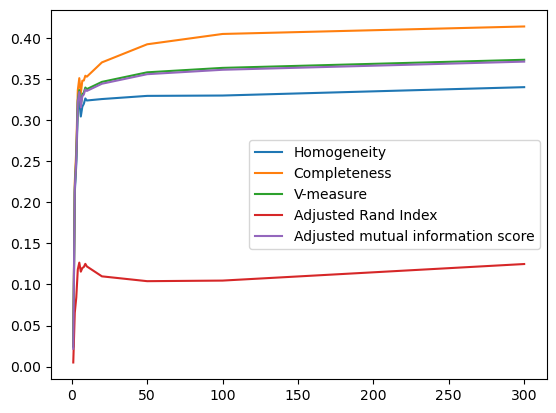

In [41]:
plt.plot(r, hom_3, label = "Homogeneity")
plt.plot(r, com_3, label = "Completeness")
plt.plot(r, v_mea_3, label = "V-measure")
plt.plot(r, adj_r_3, label = "Adjusted Rand Index")
plt.plot(r, adj_mu_3, label = "Adjusted mutual information score")
plt.legend()
plt.show()

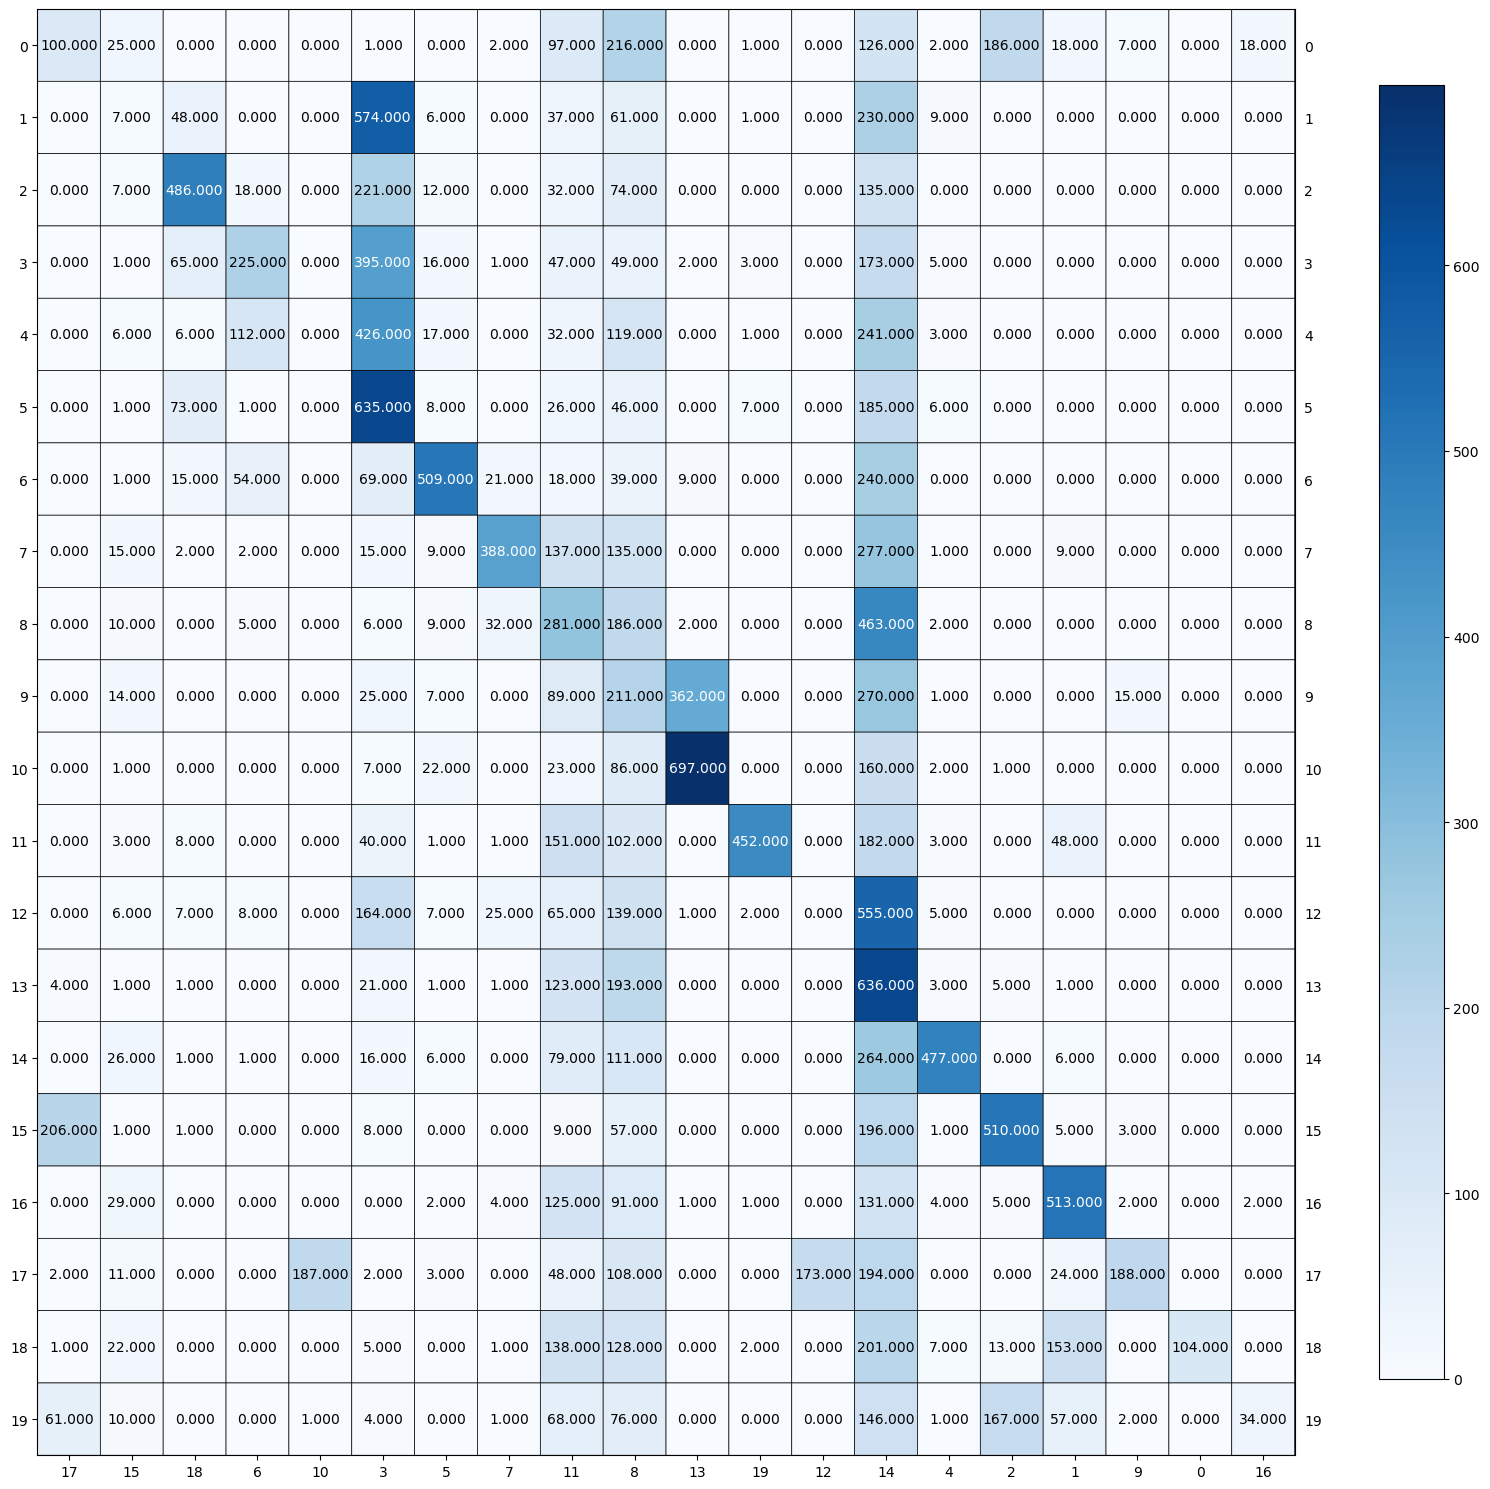

In [42]:
cm = confusion_matrix(data_train_20.target, lab_collections_20[-1])
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

In [44]:
lab_collections2_20 = []
for x in tqdm(range(len(r))):
    NMF_1 = NMF(n_components=r[x], init='random', random_state=42,max_iter=1000)
    W = NMF_1.fit_transform(data_transformed_20)
    kmeans.fit(W)
    lab_collections2_20.append(kmeans.labels_)

 64%|████████████████████████████▎               | 9/14 [00:48<00:30,  6.16s/it]/Users/felix/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
100%|██████████████████████████████████████████| 14/14 [46:47<00:00, 200.50s/it]


In [45]:
print("NMF")
hom_4 = []
com_4 = []
v_mea_4 = []
adj_r_4 = []
adj_mu_4 = []
for x in range(len(r)):
    hom_4.append(homogeneity_score(data_train_20.target,lab_collections2_20[x]))
    com_4.append(completeness_score(data_train_20.target,lab_collections2_20[x]))
    v_mea_4.append(v_measure_score(data_train_20.target,lab_collections2_20[x]))
    adj_r_4.append(adjusted_rand_score(data_train_20.target,lab_collections2_20[x]))
    adj_mu_4.append(adjusted_mutual_info_score(data_train_20.target,lab_collections2_20[x]))
    print("Homogeneity: ", homogeneity_score(data_train_20.target,lab_collections2_20[x]))
    print("Completeness: ",completeness_score(data_train_20.target,lab_collections2_20[x]))
    print("V-measure: ",v_measure_score(data_train_20.target,lab_collections2_20[x]))
    print("Adjusted Rand Index: ",adjusted_rand_score(data_train_20.target,lab_collections2_20[x]))
    print("Adjusted mutual information score: ",adjusted_mutual_info_score(data_train_20.target,lab_collections2_20[x]))
    print("Average: ",(homogeneity_score(data_train_20.target,lab_collections2_20[x])+
         completeness_score(data_train_20.target,lab_collections2_20[x])+
         v_measure_score(data_train_20.target,lab_collections2_20[x])+
         adjusted_rand_score(data_train_20.target,lab_collections2_20[x])+
          adjusted_mutual_info_score(data_train_20.target,lab_collections2_20[x]))/5
         )
    print("")

NMF
Homogeneity:  0.02414477211123332
Completeness:  0.026109012106166563
V-measure:  0.02508850456418185
Adjusted Rand Index:  0.005069466603507795
Adjusted mutual information score:  0.02177877822712708
Average:  0.02043810672244332

Homogeneity:  0.1912056689667014
Completeness:  0.20432644325820276
V-measure:  0.1975484319136985
Adjusted Rand Index:  0.05764558714976883
Adjusted mutual information score:  0.19485515419845262
Average:  0.16911625709736483

Homogeneity:  0.2186383223258225
Completeness:  0.2366967277284554
V-measure:  0.22730943047056248
Adjusted Rand Index:  0.06473139112283063
Adjusted mutual information score:  0.22470451667153774
Average:  0.19441607766384178

Homogeneity:  0.24691668549473988
Completeness:  0.2944008776362139
V-measure:  0.26857613299013133
Adjusted Rand Index:  0.07621829634185957
Adjusted mutual information score:  0.26595626537107325
Average:  0.2304136515668036

Homogeneity:  0.297368780469481
Completeness:  0.3325269314588892
V-measure:  0.

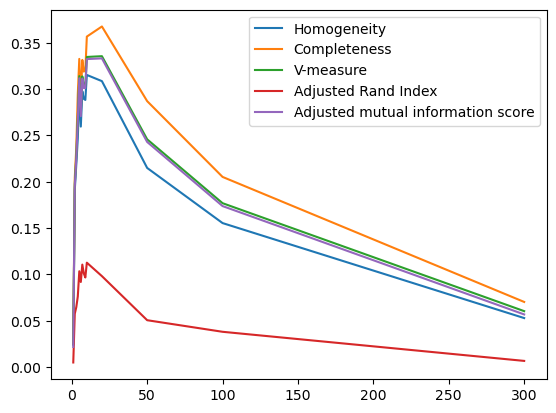

In [46]:
plt.plot(r, hom_4, label = "Homogeneity")
plt.plot(r, com_4, label = "Completeness")
plt.plot(r, v_mea_4, label = "V-measure")
plt.plot(r, adj_r_4, label = "Adjusted Rand Index")
plt.plot(r, adj_mu_4, label = "Adjusted mutual information score")
plt.legend()
plt.show()

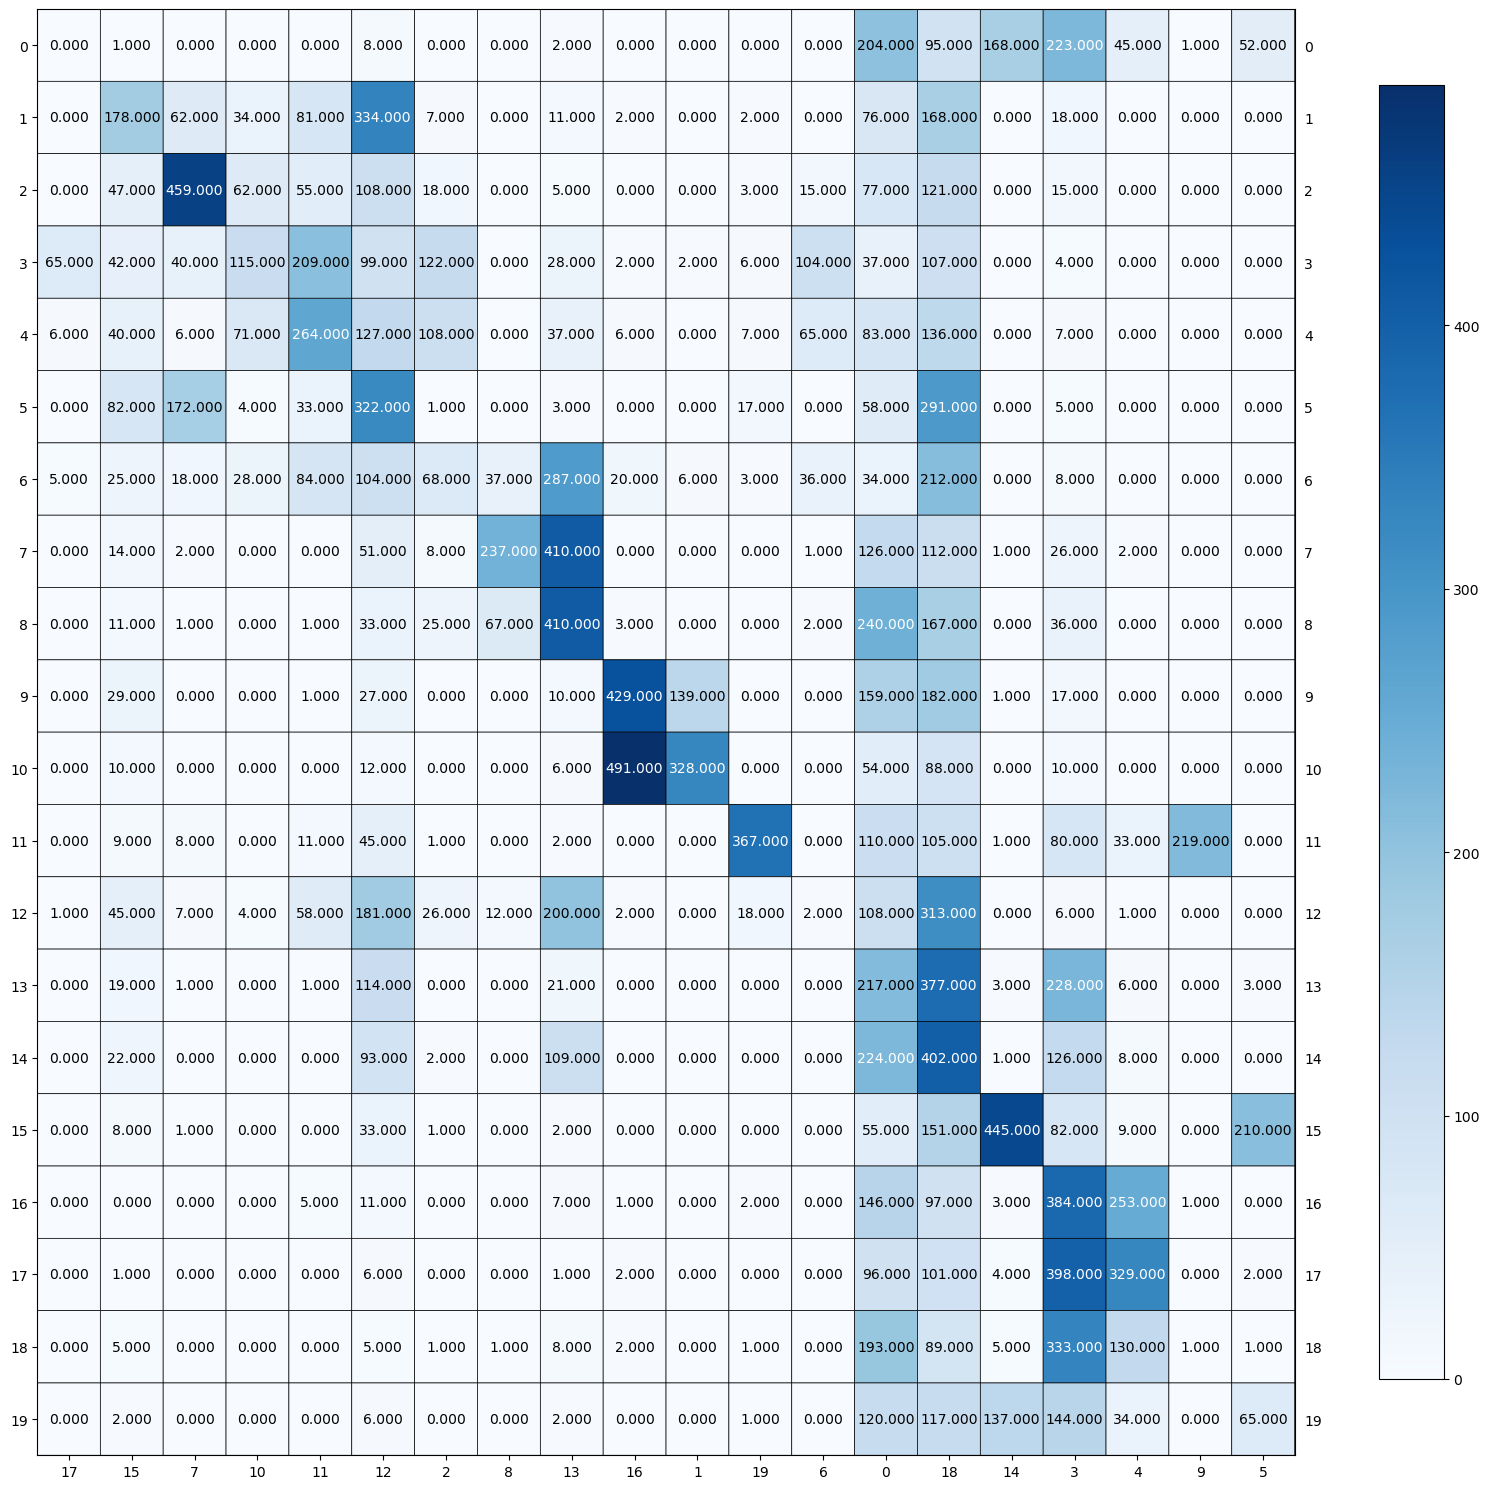

In [47]:
cm = confusion_matrix(data_train_20.target, lab_collections2_20[9])
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

In [51]:
kmeans.fit(data_transformed_20)

KMeans(max_iter=1100, n_clusters=20, n_init=40, random_state=0)

In [58]:
print("No Dimention Reduction")
print("Homogeneity: ", homogeneity_score(data_train_20.target,kmeans.labels_))
print("Completeness: ",completeness_score(data_train_20.target,kmeans.labels_))
print("V-measure: ",v_measure_score(data_train_20.target,kmeans.labels_))
print("Adjusted Rand Index: ",adjusted_rand_score(data_train_20.target,kmeans.labels_))
print("Adjusted mutual information score: ",adjusted_mutual_info_score(data_train_20.target,kmeans.labels_))
print("Average: ",(homogeneity_score(data_train_20.target,kmeans.labels_)+
     completeness_score(data_train_20.target,kmeans.labels_)+
     v_measure_score(data_train_20.target,kmeans.labels_)+
     adjusted_rand_score(data_train_20.target,kmeans.labels_)+
      adjusted_mutual_info_score(data_train_20.target,kmeans.labels_))/5
     )
print("")

No Dimention Reduction
Homogeneity:  0.34790859768457
Completeness:  0.39677714833899
V-measure:  0.37073942131701093
Adjusted Rand Index:  0.12210793219608113
Adjusted mutual information score:  0.368564014634305
Average:  0.32121942283419147



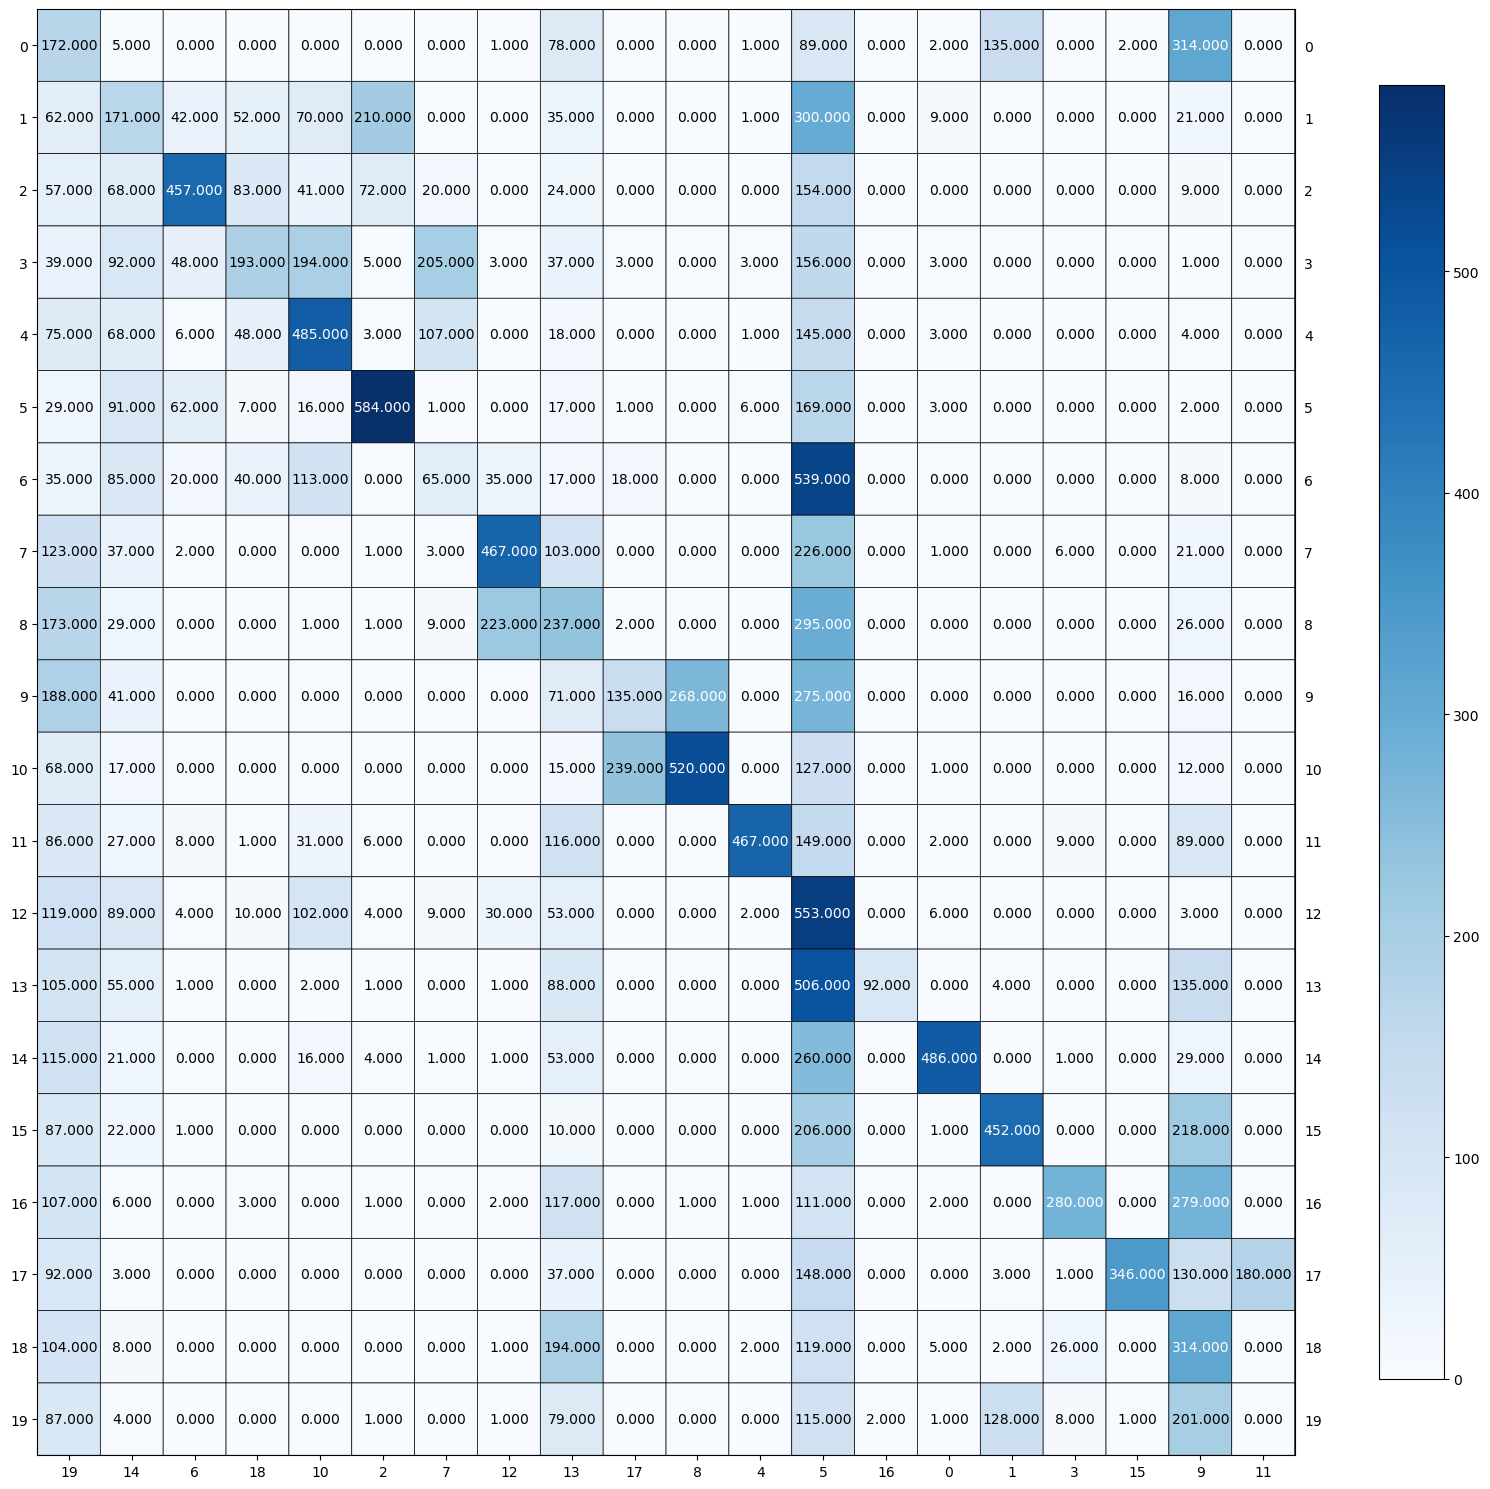

In [59]:
cm = confusion_matrix(data_train_20.target, kmeans.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

# Q11

In [60]:
from sklearn.datasets import fetch_20newsgroups
data_train = fetch_20newsgroups(subset="all",random_state=42,remove=("headers", "footers"))

In [61]:
vectorizer = CountVectorizer(min_df=3,stop_words = 'english')
pipe = Pipeline([('count', vectorizer),('tfid', TfidfTransformer())])

In [62]:
df_data = pd.DataFrame({"content":data_train.data,"label":data_train.target})

In [63]:
contents=pipe.fit_transform(df_data['content'])

In [64]:
labels=df_data['label']

In [65]:
dims=[5,20,200]
reduce_metrics=['cosine','euclidean']

In [66]:
kmeans = KMeans(
        n_clusters=20,
        max_iter=1100,
        n_init=40,
        random_state=0,
)

In [67]:
import umap

In [68]:
from collections import defaultdict

In [69]:
evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5,hasSeed=True):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        if hasSeed:
            km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(completeness_score(labels, km.labels_))
        scores["V-measure"].append(v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

 inner loop:   0%|                                        | 0/2 [00:00<?, ?it/s]

KMeans using umap with n_components 5 metrics cosine


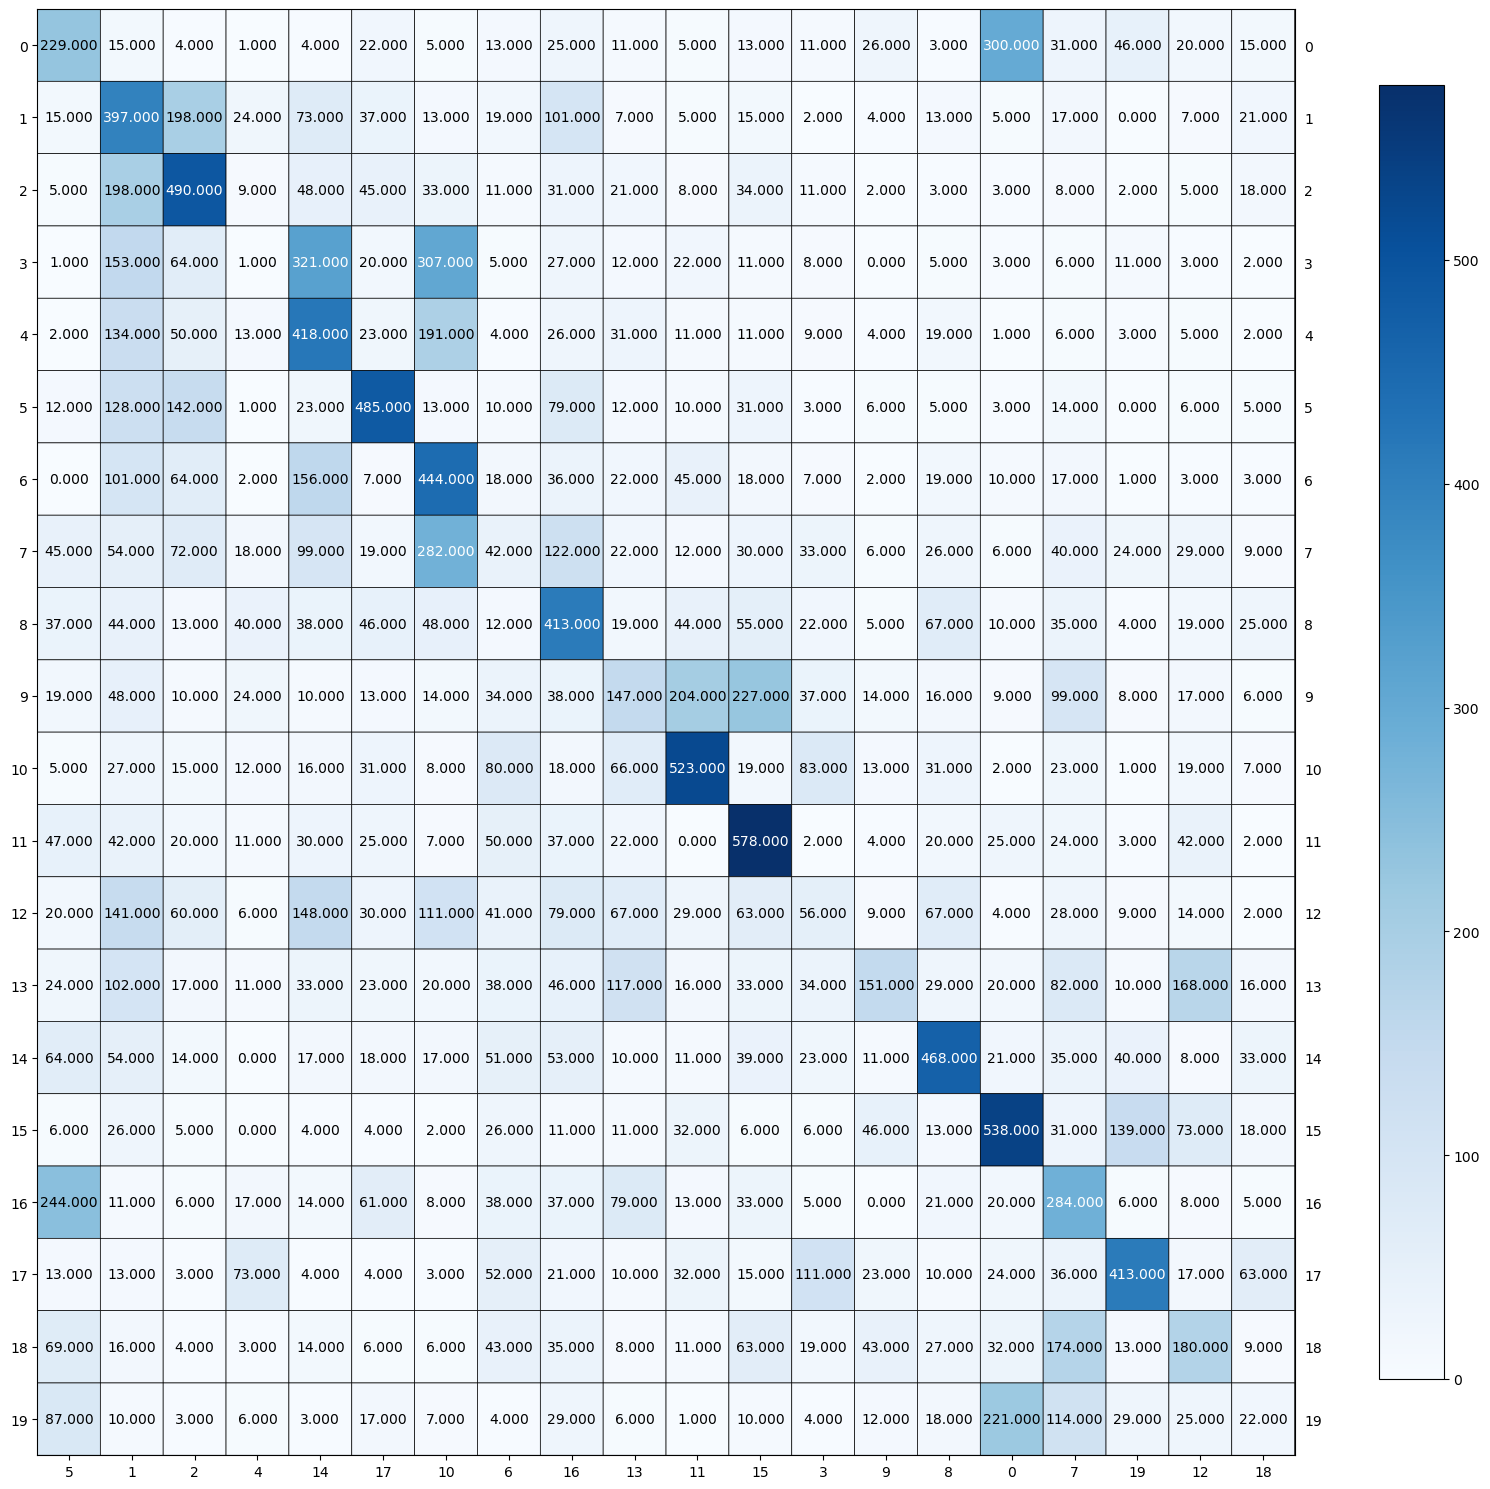


 inner loop:  50%|████████████████                | 1/2 [00:14<00:14, 14.58s/it]

Homogeneity:  0.269849618855689
Completeness:  0.2789383088099403
V-measure:  0.2743187031711635
Adjusted Rand Index:  0.15665527898741563
Adjusted mutual information score:  0.2719352290367982
Average:  0.25033942777220136




KMeans using umap with n_components 5 metrics euclidean


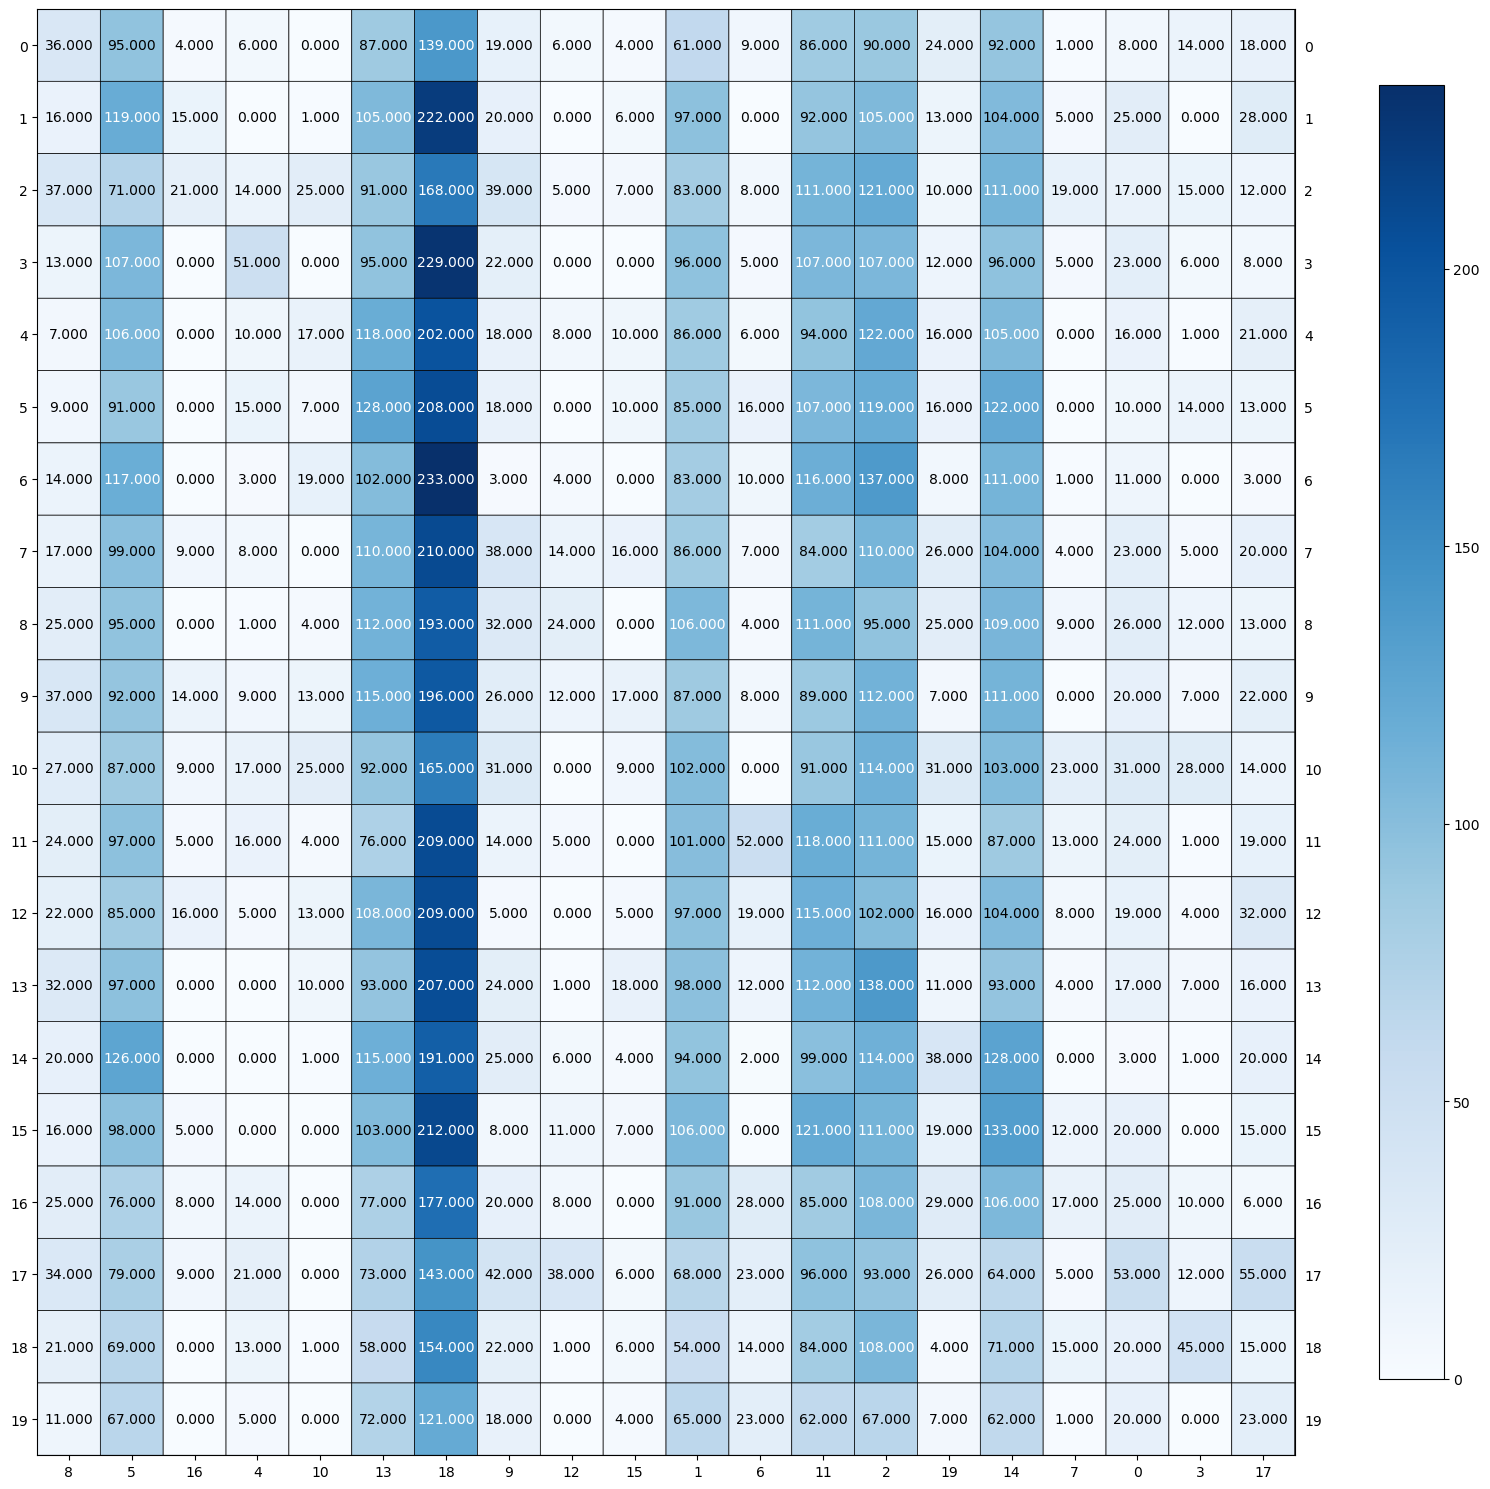


 outer:  33%|████████████▎                        | 1/3 [00:26<00:53, 26.76s/it]

Homogeneity:  0.019617738013073673
Completeness:  0.023749540632678836
V-measure:  0.02148681128315963
Adjusted Rand Index:  0.001467821635725807
Adjusted mutual information score:  0.01799063444585558
Average:  0.016862509202098707







 inner loop:   0%|                                        | 0/2 [00:00<?, ?it/s]

KMeans using umap with n_components 20 metrics cosine


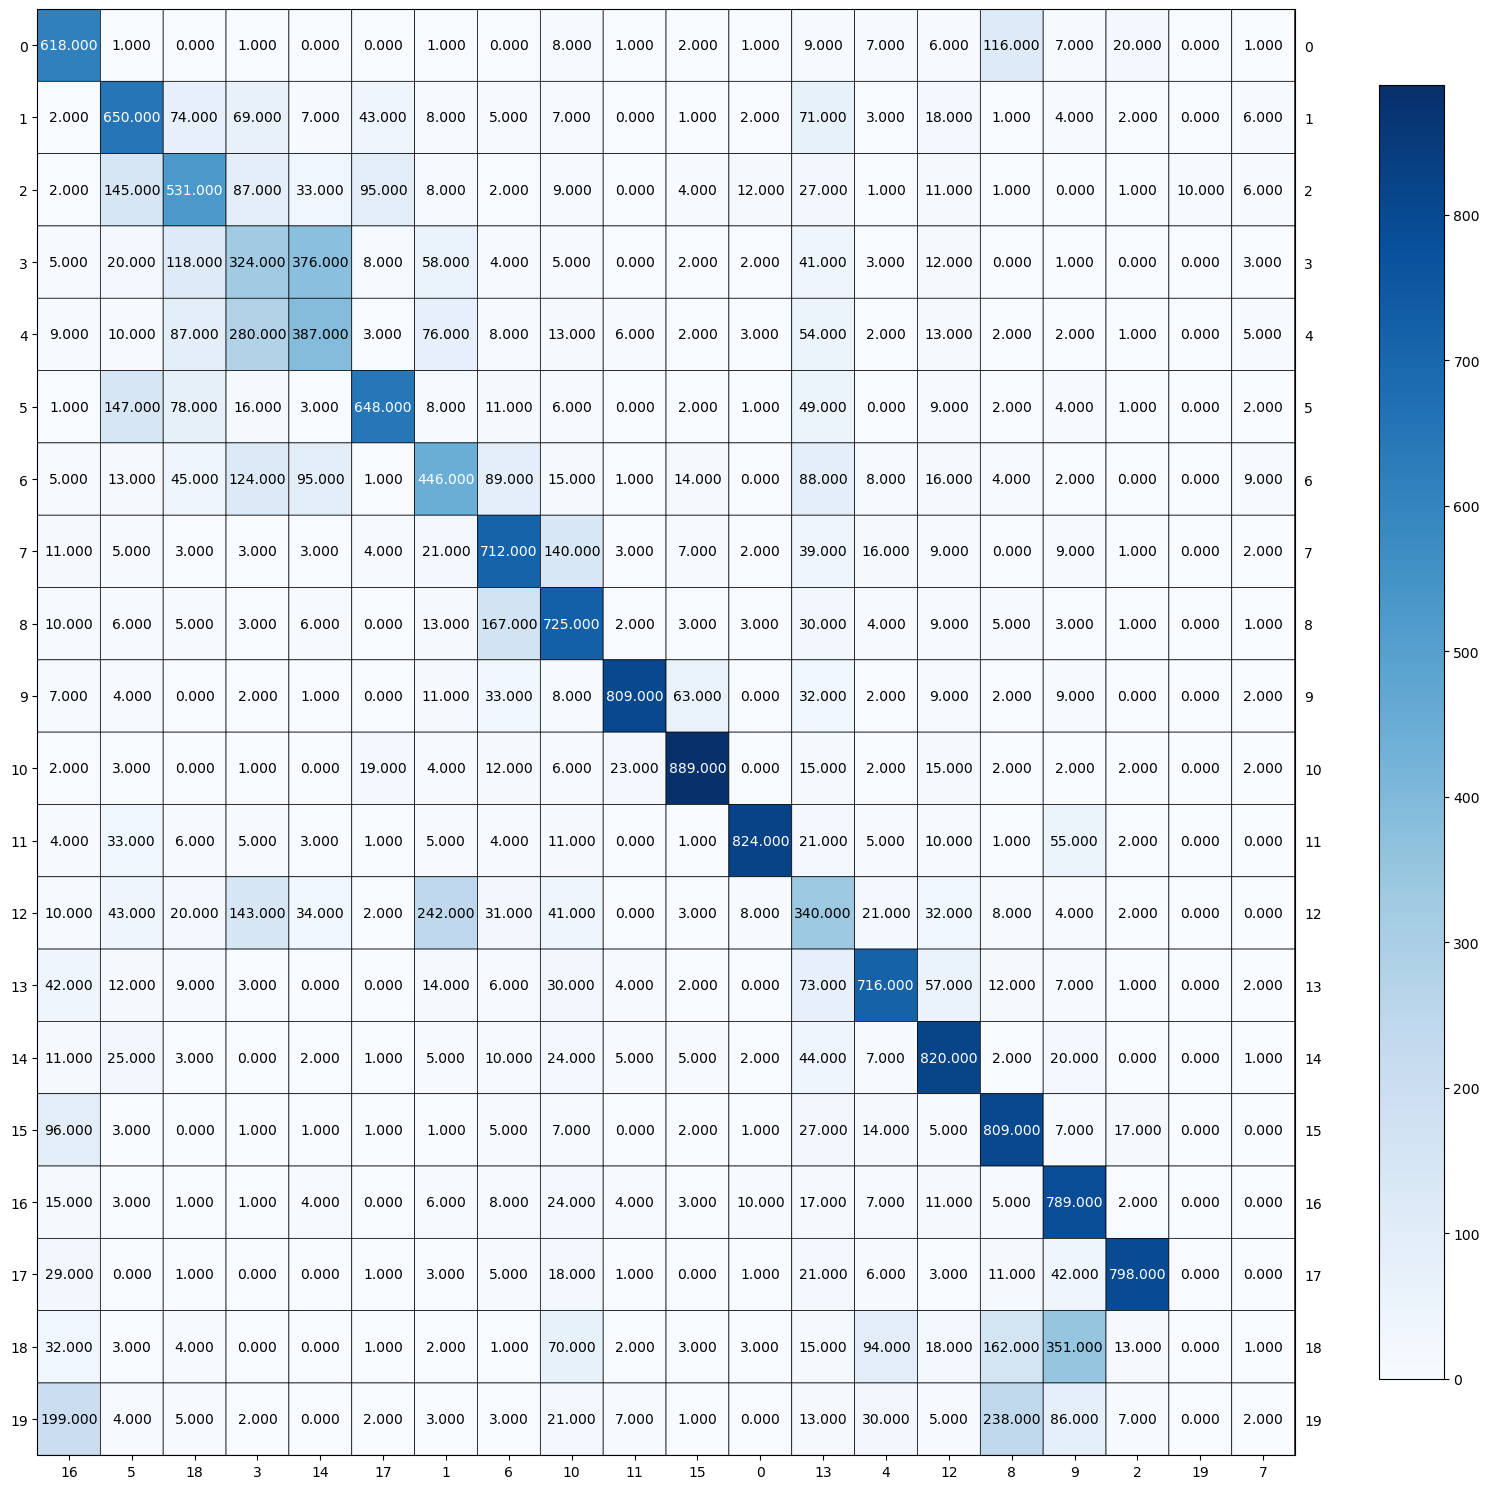


 inner loop:  50%|████████████████                | 1/2 [00:23<00:23, 23.05s/it]

Homogeneity:  0.5675204514312507
Completeness:  0.586776457379573
V-measure:  0.5769878398519761
Adjusted Rand Index:  0.4537327765120024
Adjusted mutual information score:  0.5755893219320715
Average:  0.5521213694213747




KMeans using umap with n_components 20 metrics euclidean


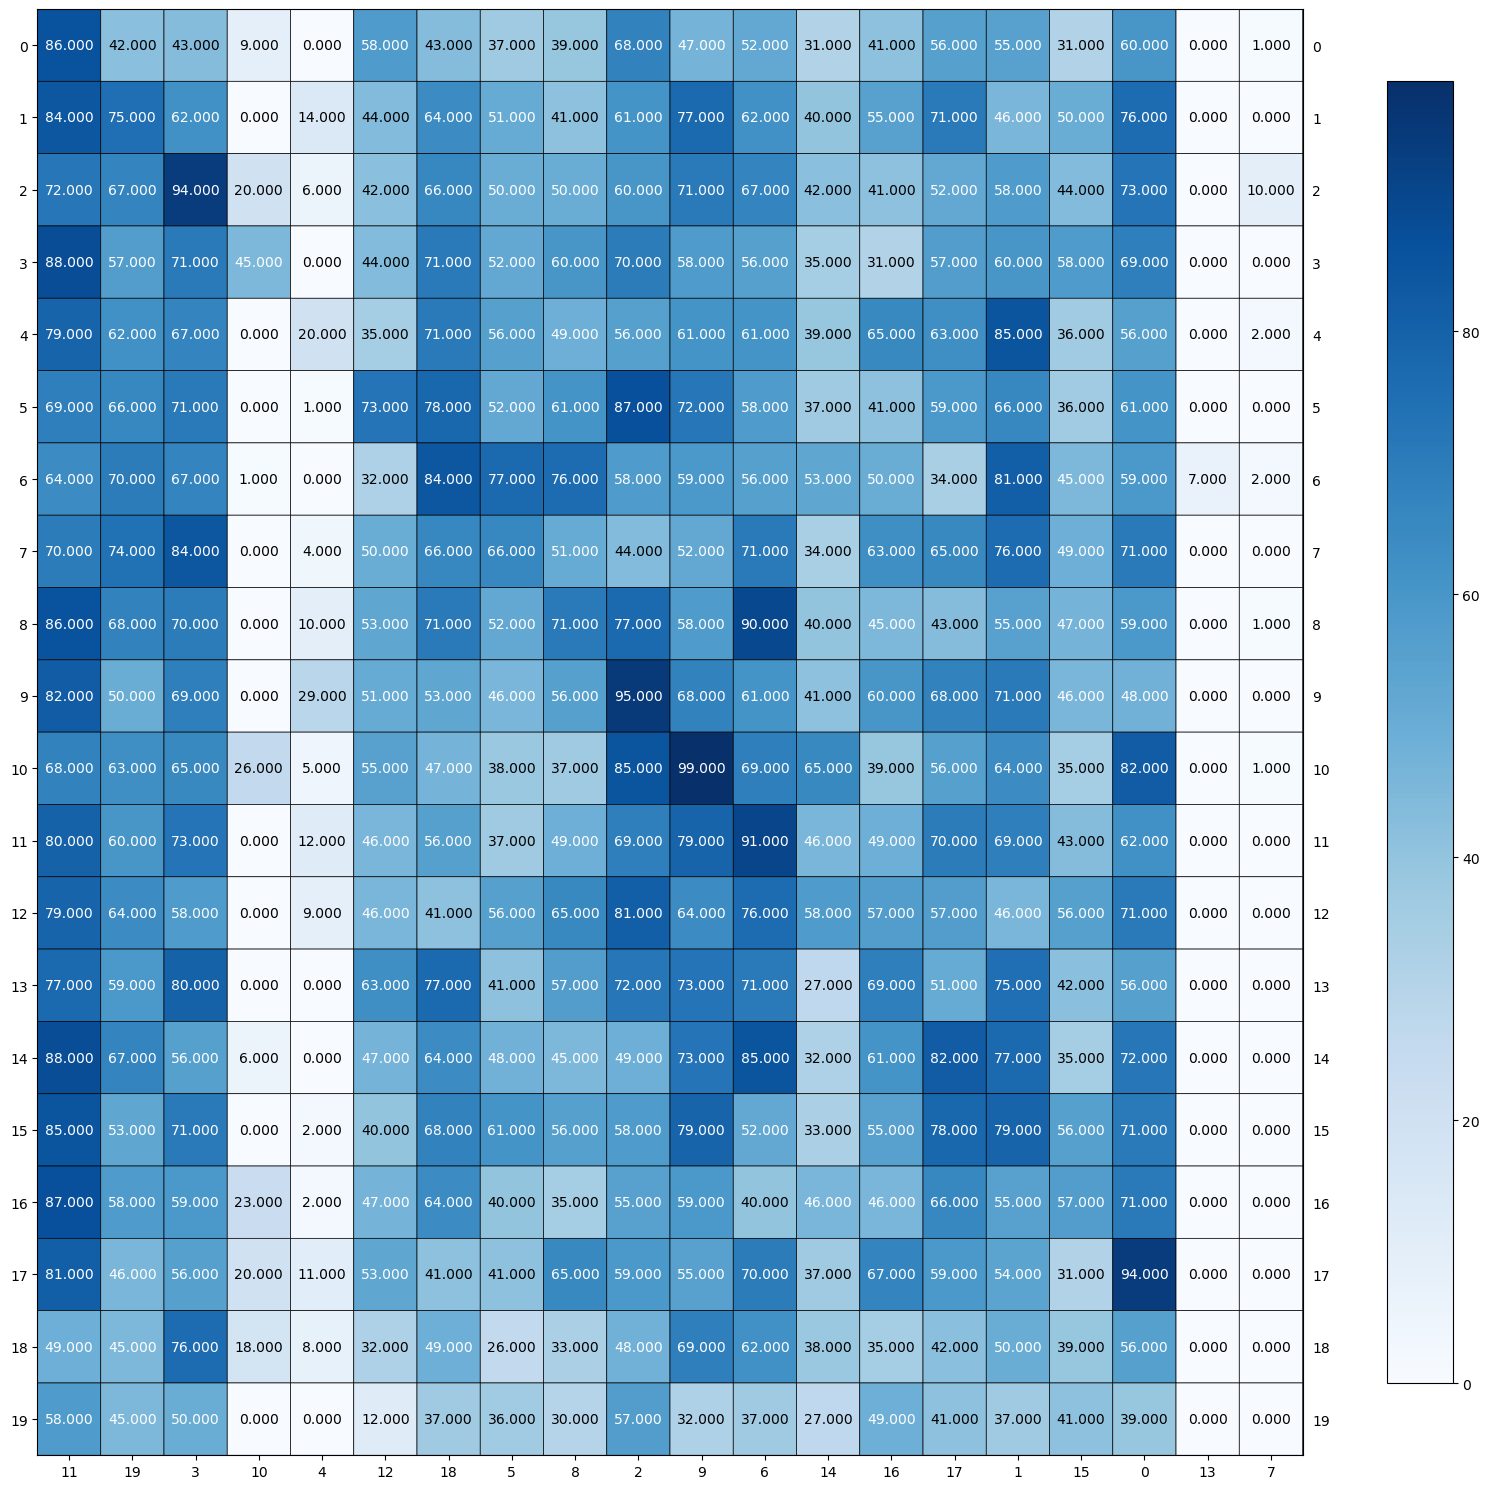


 outer:  67%|████████████████████████▋            | 2/3 [01:17<00:40, 40.62s/it]

Homogeneity:  0.010802118457913798
Completeness:  0.01147887995543727
V-measure:  0.011130221253326376
Adjusted Rand Index:  0.001163079430442902
Adjusted mutual information score:  0.007826418180672319
Average:  0.008480143455558533







 inner loop:   0%|                                        | 0/2 [00:00<?, ?it/s]

KMeans using umap with n_components 200 metrics cosine


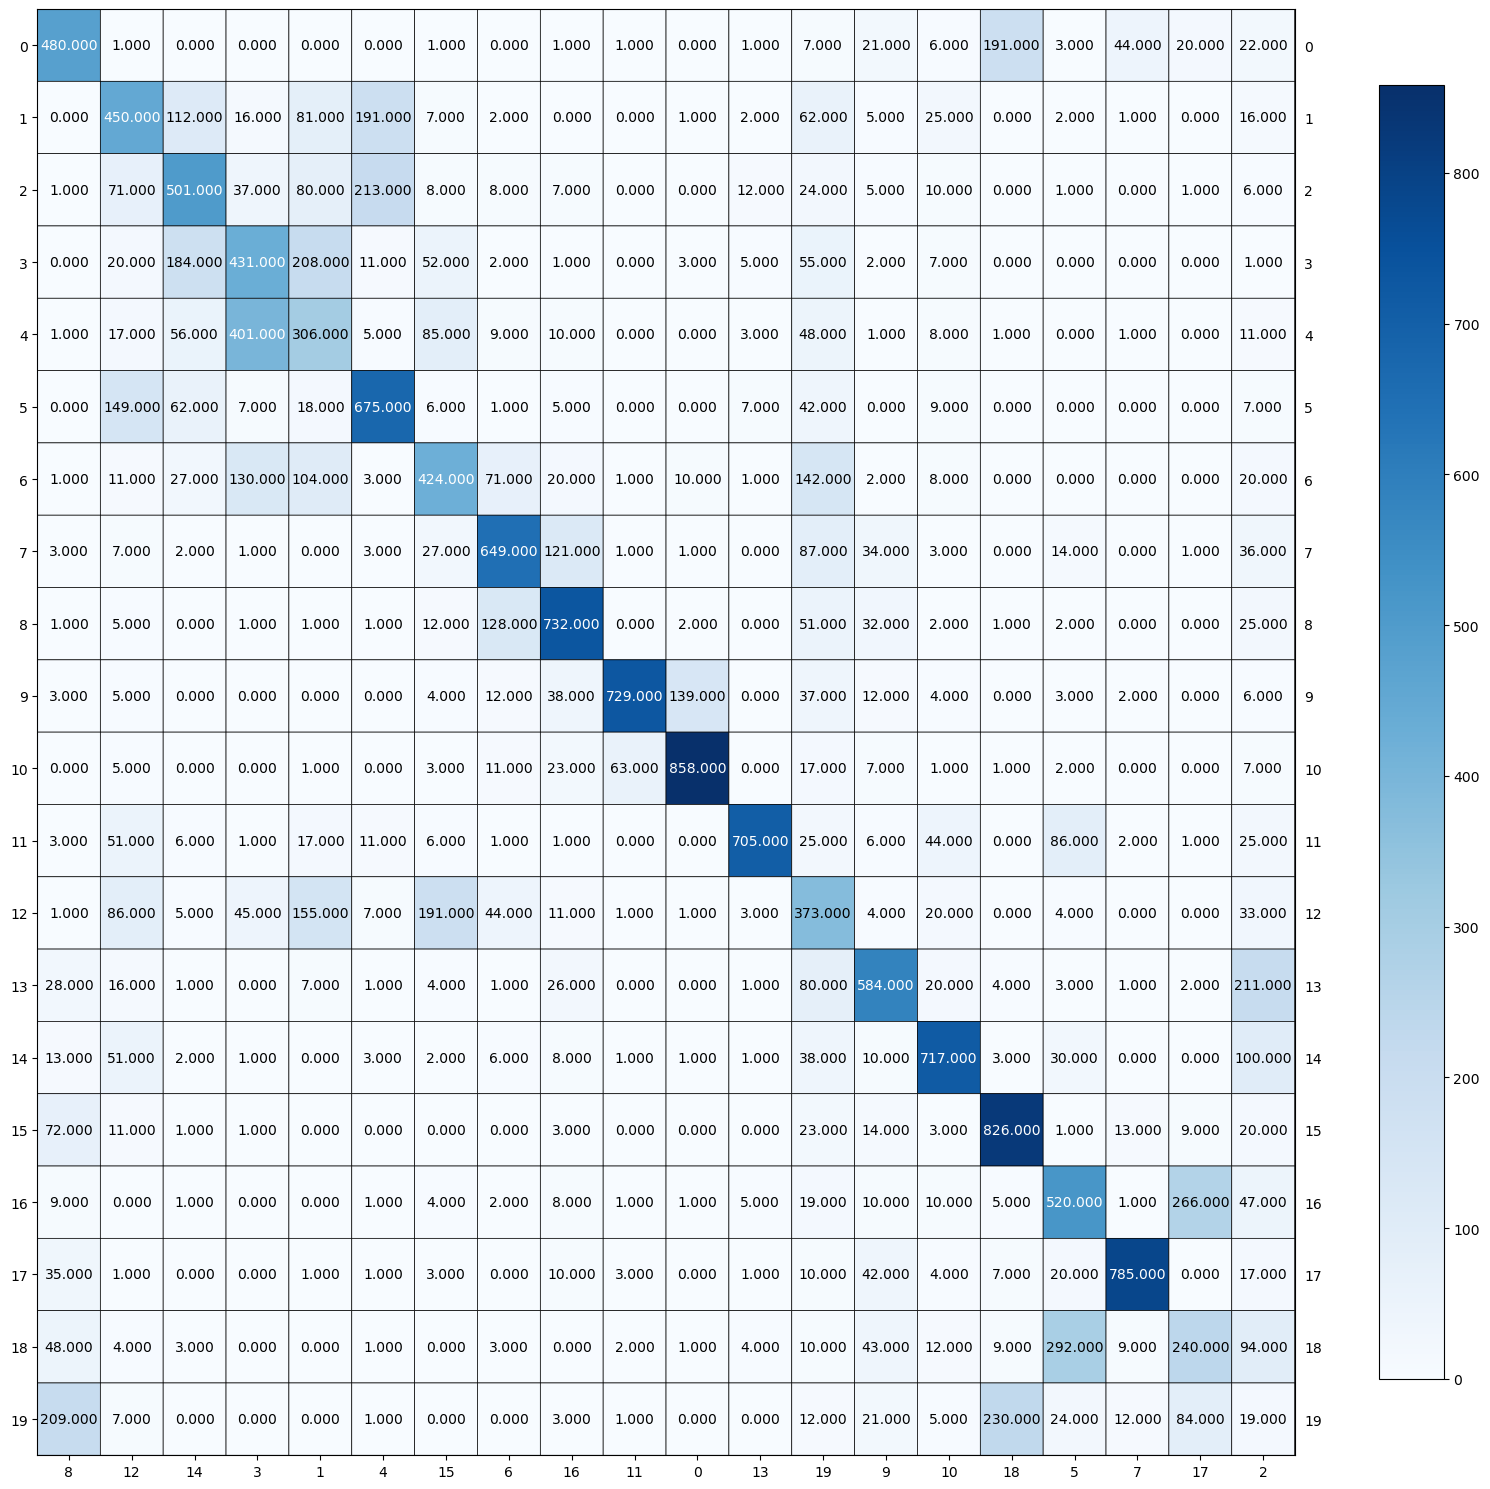


 inner loop:  50%|███████████████▌               | 1/2 [05:36<05:36, 336.28s/it]

Homogeneity:  0.5648023709225738
Completeness:  0.5662550226299147
V-measure:  0.5655277639336692
Adjusted Rand Index:  0.4096891710780805
Adjusted mutual information score:  0.564124079534736
Average:  0.5340796816197948




KMeans using umap with n_components 200 metrics euclidean


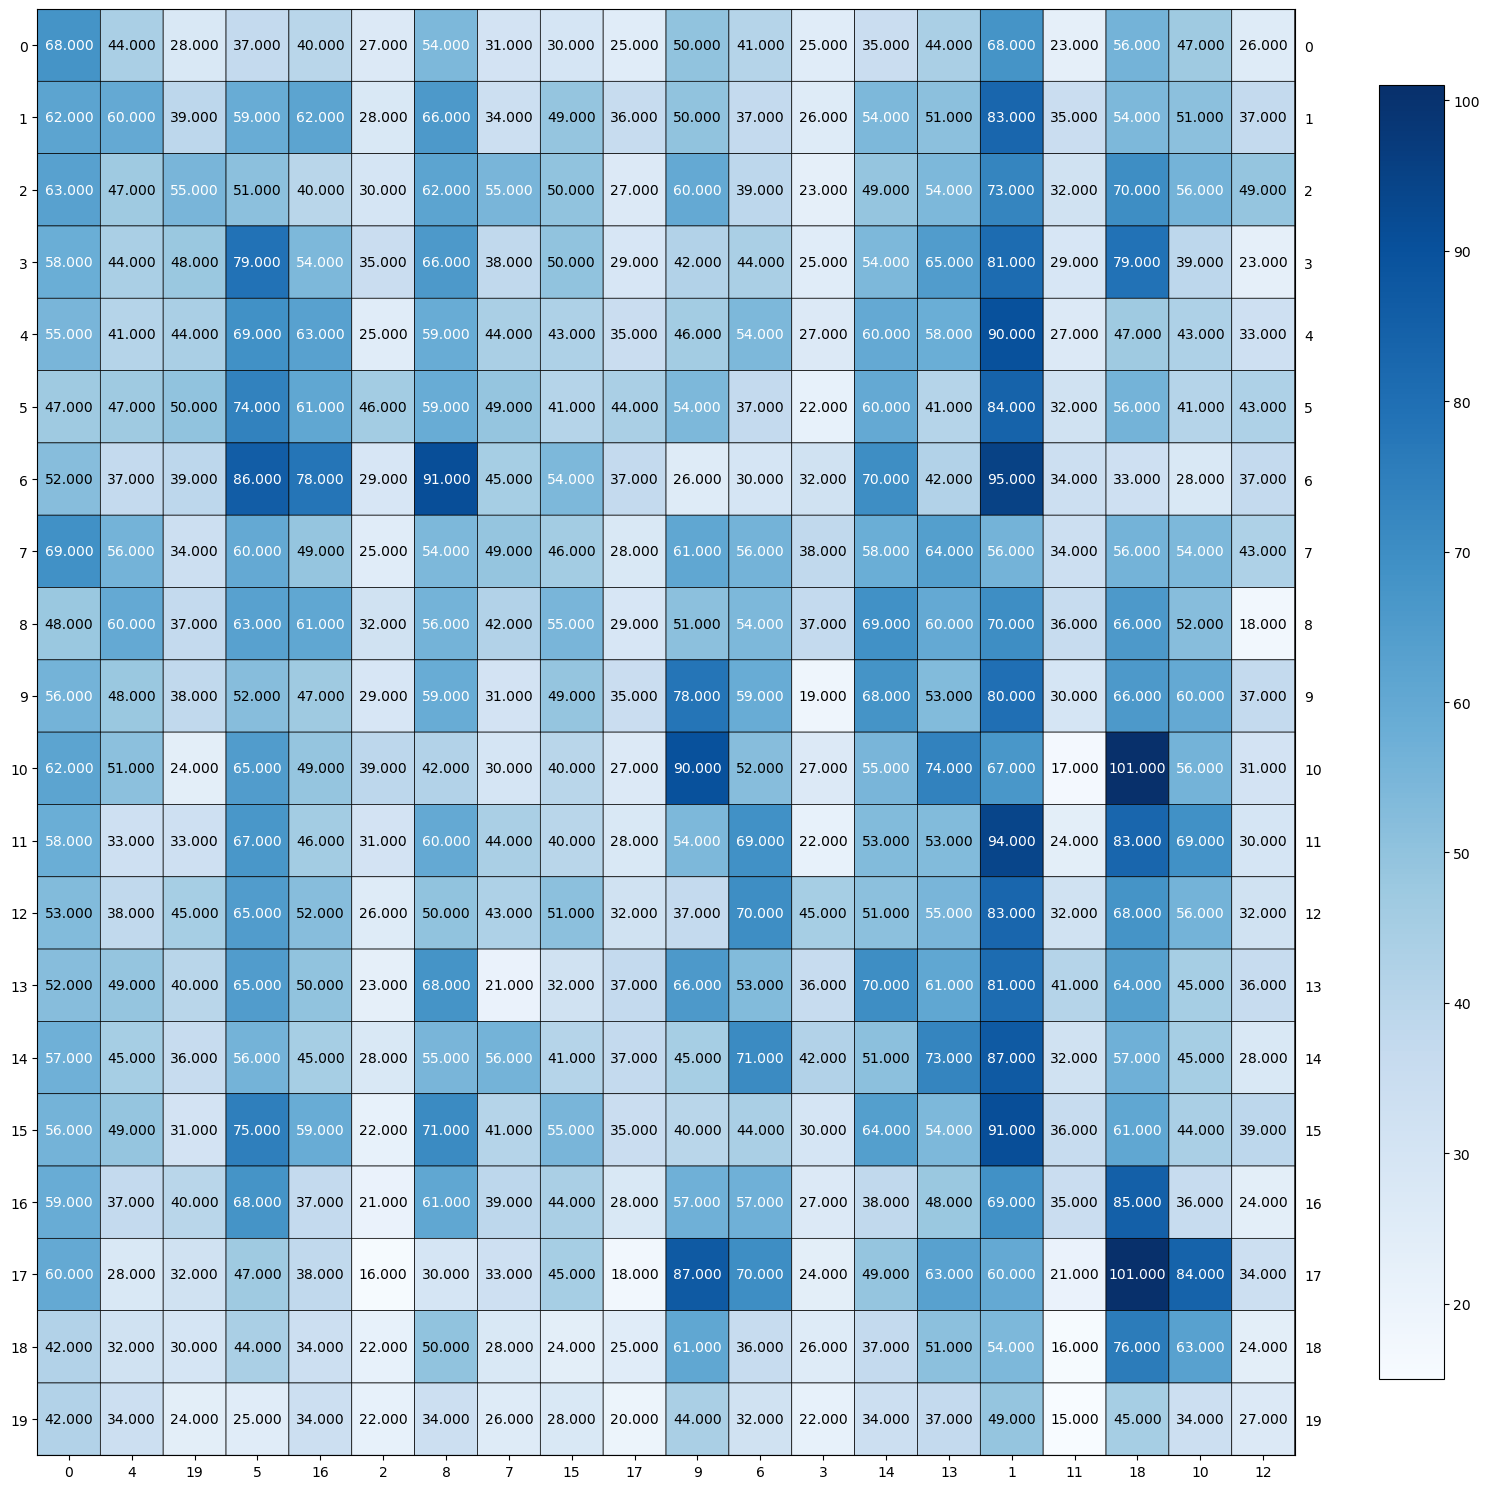


 outer: 100%|████████████████████████████████████| 3/3 [15:21<00:00, 307.23s/it]

Homogeneity:  0.006638457414285602
Completeness:  0.00671448489577333
V-measure:  0.006676254716666776
Adjusted Rand Index:  0.0011760560280208168
Adjusted mutual information score:  0.0034520426464795585
Average:  0.004931459140245217






In [70]:
for dim in tqdm(dims, desc=" outer", position=0):
    for m in tqdm(reduce_metrics, desc=" inner loop", position=1, leave=False):
        umap_reducer=umap.UMAP(dim,metric=m)
        df_umap=umap_reducer.fit_transform(contents)
        kmeans.fit(df_umap)
        cm = confusion_matrix(labels,kmeans.labels_)
        rows, cols = linear_sum_assignment(cm, maximize=True)
        print('KMeans using umap with n_components {} metrics {}'.format(dim,m))
        plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))
        print("Homogeneity: ", homogeneity_score(data_train.target,kmeans.labels_))
        print("Completeness: ",completeness_score(data_train.target,kmeans.labels_))
        print("V-measure: ",v_measure_score(data_train.target,kmeans.labels_))
        print("Adjusted Rand Index: ",adjusted_rand_score(data_train.target,kmeans.labels_))
        print("Adjusted mutual information score: ",adjusted_mutual_info_score(data_train.target,kmeans.labels_))
        print("Average: ",(homogeneity_score(data_train.target,kmeans.labels_)+
         completeness_score(data_train.target,kmeans.labels_)+
         v_measure_score(data_train.target,kmeans.labels_)+
         adjusted_rand_score(data_train.target,kmeans.labels_)+
          adjusted_mutual_info_score(data_train.target,kmeans.labels_))/5
         )
        print("")
        print('\n\n')

# Q12

In [71]:

#from the contingency matrix, we can see that KMeans using euclidean as metric randomly cluster these 20 categories no matter
#how many components we use when reducing the features with umap. While KMeans using cosine as metric is able to correctly cluster
#these 20 categories as we can see from the diagonal of the matrix. From the matrix, we can see that KMeans using umap with n_components
#of 20 and with a metric of cosine works the best since under this setting, more data points are correctly clustered to its own category
#since each class is heavily clustered into one cluster, which is unlike other setting. Data points from the same class are clustered into 
#more than one cluster. 


#from the metric, we can see that under the setting of 20 n_components and with a metric of cosine, we have the highest adjusted rand score,
#highest homogeneity, completeness, V-measure, and Silhouette Coefficient. This means that not only this setting can correctly 
#cluster data points of the same category, it also can cluster most data points of the same class into the same cluster according to completeness among
#all these setting, the cluster under this setting also contains most data points from a single class.

best_dim=20
best_metric='cosine'


# Q13

In [72]:
# UMAP with dimention=20 and metric = cosine works the best for K-Means clustering task on the 20-class text data

# Q14

In [73]:
#Q14
linkages=['single','ward','average','complete']
umap_reducer=umap.UMAP(n_components=best_dim,metric=best_metric)
df_umap=umap_reducer.fit_transform(contents)
for l in linkages:
    print('agglomerative clustering with {} as linkage'.format(l))
    agglo_clus=AgglomerativeClustering(n_clusters=20,linkage=l)
    agglo_clus.fit(df_umap)
    #fit_and_evaluate(agglo_clus,df_umap,'agglomerative clustering using linkage {}'.format(l),hasSeed=False)
    print("Homogeneity: ", homogeneity_score(data_train.target,agglo_clus.labels_))
    print("Completeness: ",completeness_score(data_train.target,agglo_clus.labels_))
    print("V-measure: ",v_measure_score(data_train.target,agglo_clus.labels_))
    print("Adjusted Rand Index: ",adjusted_rand_score(data_train.target,agglo_clus.labels_))
    print("Adjusted mutual information score: ",adjusted_mutual_info_score(data_train.target,agglo_clus.labels_))
    print("Average: ",(homogeneity_score(data_train.target,agglo_clus.labels_)+
     completeness_score(data_train.target,agglo_clus.labels_)+
     v_measure_score(data_train.target,agglo_clus.labels_)+
     adjusted_rand_score(data_train.target,agglo_clus.labels_)+
      adjusted_mutual_info_score(data_train.target,agglo_clus.labels_))/5
     )
    print('\n\n')

agglomerative clustering with single as linkage
Homogeneity:  0.018518066200508162
Completeness:  0.3784553878324676
V-measure:  0.03530846637034055
Adjusted Rand Index:  0.00046584897265122957
Adjusted mutual information score:  0.030335846120322786
Average:  0.09261672309925809



agglomerative clustering with ward as linkage
Homogeneity:  0.5454727582859332
Completeness:  0.5860841782559056
V-measure:  0.5650496991835158
Adjusted Rand Index:  0.414728873671653
Adjusted mutual information score:  0.563581383525731
Average:  0.5349833785845477



agglomerative clustering with average as linkage
Homogeneity:  0.49786642279858495
Completeness:  0.6122221908347892
V-measure:  0.5491541276352487
Adjusted Rand Index:  0.35527965289559293
Adjusted mutual information score:  0.5475130100562092
Average:  0.512407080844085



agglomerative clustering with complete as linkage
Homogeneity:  0.5253430484642387
Completeness:  0.5879411059108111
V-measure:  0.5548821865159991
Adjusted Rand Index:  

In [74]:
# agglomerative clustering with ward linkage has a higher accuracy compared to agglomerative clustering with complete linkage
# while with complete linkage the completeness is higher than using ward linkage

# Q15

In [75]:
#Q15
hdbscan_clus=hdbscan.HDBSCAN(min_cluster_size=100)
#fit_and_evaluate(hdbscan_clus,df_umap,'hdbscan with min_cluster_size=100',hasSeed=False)
hdbscan_clus.fit(df_umap)
print("Homogeneity: ", homogeneity_score(data_train.target,hdbscan_clus.labels_))
print("Completeness: ",completeness_score(data_train.target,hdbscan_clus.labels_))
print("V-measure: ",v_measure_score(data_train.target,hdbscan_clus.labels_))
print("Adjusted Rand Index: ",adjusted_rand_score(data_train.target,hdbscan_clus.labels_))
print("Adjusted mutual information score: ",adjusted_mutual_info_score(data_train.target,hdbscan_clus.labels_))
print("Average: ",(homogeneity_score(data_train.target,hdbscan_clus.labels_)+
 completeness_score(data_train.target,hdbscan_clus.labels_)+
 v_measure_score(data_train.target,hdbscan_clus.labels_)+
 adjusted_rand_score(data_train.target,hdbscan_clus.labels_)+
  adjusted_mutual_info_score(data_train.target,hdbscan_clus.labels_))/5
 )
print('\n\n')
cluster_size_options=[20,100,200]
for sz in tqdm(cluster_size_options):
    print('HDBSCAN with a min_cluster_size of {}'.format(sz))
    hdbscan_clus=hdbscan.HDBSCAN(min_cluster_size=sz,min_samples=100)
    #fit_and_evaluate(hdbscan_clus,df_umap,'hdbscan with min_cluster_size={}'.format(sz),hasSeed=False)
    hdbscan_clus.fit(df_umap)
    print("Homogeneity: ", homogeneity_score(data_train.target,hdbscan_clus.labels_))
    print("Completeness: ",completeness_score(data_train.target,hdbscan_clus.labels_))
    print("V-measure: ",v_measure_score(data_train.target,hdbscan_clus.labels_))
    print("Adjusted Rand Index: ",adjusted_rand_score(data_train.target,hdbscan_clus.labels_))
    print("Adjusted mutual information score: ",adjusted_mutual_info_score(data_train.target,hdbscan_clus.labels_))
    print("Average: ",(homogeneity_score(data_train.target,hdbscan_clus.labels_)+
     completeness_score(data_train.target,hdbscan_clus.labels_)+
     v_measure_score(data_train.target,hdbscan_clus.labels_)+
     adjusted_rand_score(data_train.target,hdbscan_clus.labels_)+
      adjusted_mutual_info_score(data_train.target,hdbscan_clus.labels_))/5
     )
    print('\n\n')

# finding
# the adjusted rand score of 


Homogeneity:  0.4014796237127924
Completeness:  0.5965591103800566
V-measure:  0.47995397167729903
Adjusted Rand Index:  0.1826151459051232
Adjusted mutual information score:  0.47868226442277634
Average:  0.42785802321960953





  0%|                                                     | 0/3 [00:00<?, ?it/s]

HDBSCAN with a min_cluster_size of 20


 33%|███████████████                              | 1/3 [00:00<00:01,  1.10it/s]

Homogeneity:  0.4014796237127924
Completeness:  0.5965591103800566
V-measure:  0.47995397167729903
Adjusted Rand Index:  0.1826151459051232
Adjusted mutual information score:  0.47868226442277634
Average:  0.42785802321960953



HDBSCAN with a min_cluster_size of 100


 67%|██████████████████████████████               | 2/3 [00:01<00:00,  1.11it/s]

Homogeneity:  0.4014796237127924
Completeness:  0.5965591103800566
V-measure:  0.47995397167729903
Adjusted Rand Index:  0.1826151459051232
Adjusted mutual information score:  0.47868226442277634
Average:  0.42785802321960953



HDBSCAN with a min_cluster_size of 200


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]

Homogeneity:  0.4029942212998046
Completeness:  0.5995602021644008
V-measure:  0.48200734272102636
Adjusted Rand Index:  0.19626501027391074
Adjusted mutual information score:  0.4809551993595842
Average:  0.43235639516374536





# Q16

HDBSCAN with min_cluster_size of 100, min_samples of 100


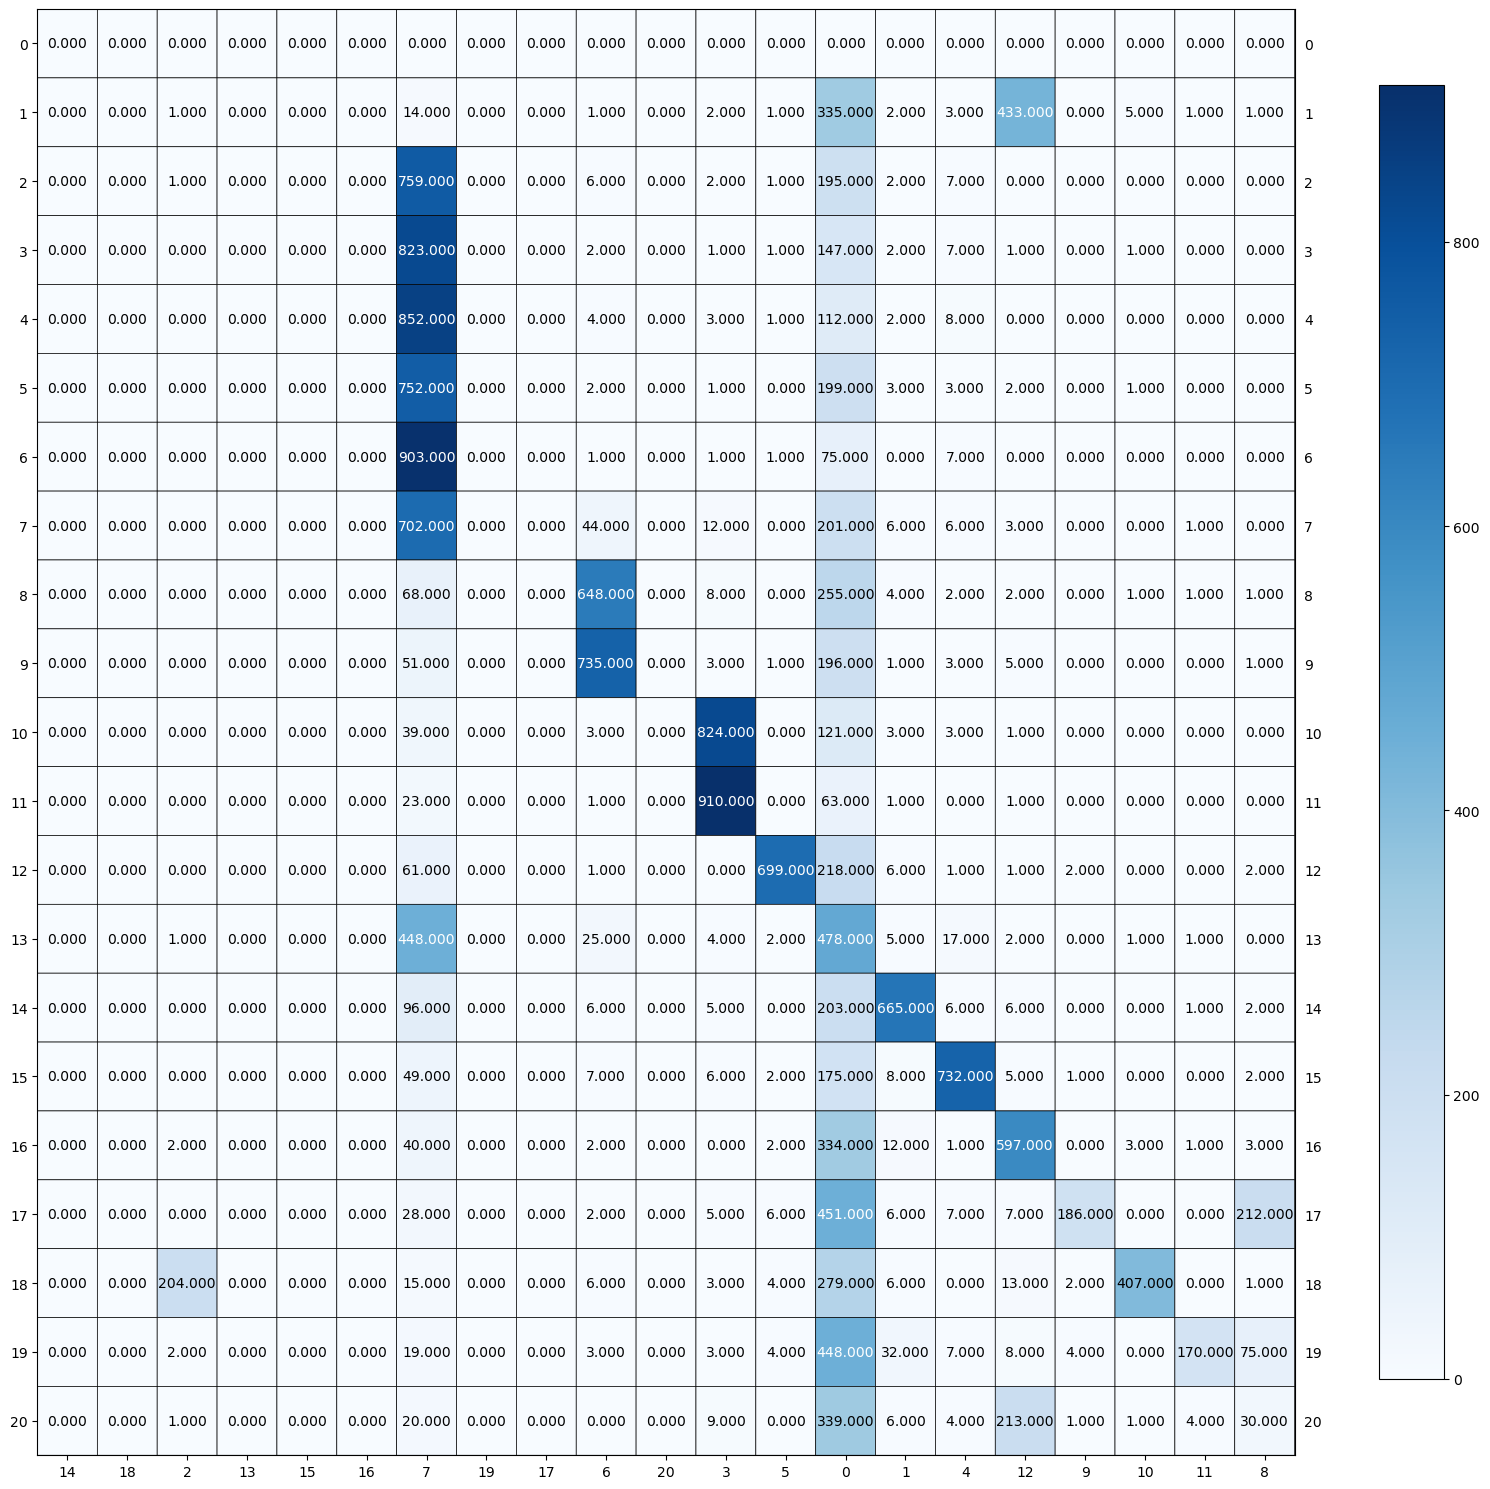

In [76]:
#16 plot the best one's contigency matrix
#-1 indicates data points that are not assigned to any cluster

hdbscan_clus=hdbscan.HDBSCAN(min_cluster_size=100,min_samples=100)
hdbscan_clus.fit(df_umap)
cm = confusion_matrix(labels,hdbscan_clus.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
print('HDBSCAN with min_cluster_size of 100, min_samples of 100')
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

# Q17

In [77]:
# svd5=TruncatedSVD(n_components=5)
# X_SVD5=svd5.fit_transform(contents)
# print(1)
# svd20=TruncatedSVD(n_components=20)
# X_SVD20=svd20.fit_transform(contents)
# print(2)
# svd200=TruncatedSVD(n_components=200)
# X_SVD200=svd200.fit_transform(contents)

In [78]:

# nmf5=NMF(n_components=5, init='random', random_state=42,max_iter=1000)
# X_NMF5=nmf5.fit_transform(contents)
# with open('X_NMF5.pickle', 'wb') as f:
#     pickle.dump(X_NMF5,f)
# print(4)
# nmf20=NMF(n_components=20, init='random', random_state=42,max_iter=1000)
# X_NMF20=nmf20.fit_transform(contents)
# print(5)
# nmf200=NMF(n_components=200, init='random', random_state=42,max_iter=1000)
# X_NMF200=nmf200.fit_transform(contents)


In [79]:
# umap5=umap.UMAP(n_components=5,metric='cosine')
# X_UMAP5=umap5.fit_transform(contents)
# print(7)
# umap20=umap.UMAP(n_components=20,metric='cosine')
# X_UMAP20=umap20.fit_transform(contents)
# print(8)

In [80]:
# umap200=umap.UMAP(n_components=200,metric='cosine')
# X_UMAP200=umap200.fit_transform(contents)

In [81]:
# Save data

# with open('X_NMF5.pickle', 'wb') as f:
#     pickle.dump(X_NMF5,f)
# with open('X_NMF20.pickle', 'wb') as f:
#     pickle.dump(X_NMF20,f)
# with open('X_NMF200.pickle', 'wb') as f:
#     pickle.dump(X_NMF200,f)
# with open('X_SVD5.pickle', 'wb') as f:
#     pickle.dump(X_SVD5,f)
# with open('X_SVD20.pickle', 'wb') as f:
#     pickle.dump(X_SVD20,f)
# with open('X_SVD200.pickle', 'wb') as f:
#     pickle.dump(X_SVD200,f)
# with open('X_UMAP5.pickle', 'wb') as f:
#     pickle.dump(X_UMAP5,f)
# with open('X_UMAP20.pickle', 'wb') as f:
#     pickle.dump(X_UMAP20,f)
# with open('X_UMAP200.pickle', 'wb') as f:
#     pickle.dump(X_UMAP200,f)

In [82]:
contents_dense = contents.toarray()

In [83]:
# Load data
with open('X_NMF5.pickle', 'rb') as f:
    X_NMF5 = pickle.load(f)
with open('X_NMF20.pickle', 'rb') as f:
    X_NMF20 = pickle.load(f)
with open('X_NMF200.pickle', 'rb') as f:
    X_NMF200 = pickle.load(f)
with open('X_SVD5.pickle', 'rb') as f:
    X_SVD5 =  pickle.load(f)
with open('X_SVD20.pickle', 'rb') as f:
    X_SVD20 =  pickle.load(f)
with open('X_SVD200.pickle', 'rb') as f:
    X_SVD200 =  pickle.load(f)
with open('X_UMAP5.pickle', 'rb') as f:
    X_UMAP5 =  pickle.load(f)
with open('X_UMAP20.pickle', 'rb') as f:
    X_UMAP20 =  pickle.load(f)
with open('X_UMAP200.pickle', 'rb') as f:
    X_UMAP200 =  pickle.load(f)

In [84]:
df_q17 = pd.DataFrame()


In [85]:
#First time

# cont = [contents]
# svds=[X_SVD5,X_SVD20,X_SVD200]
# nmfs=[X_NMF5,X_NMF20,X_NMF200]
# umaps=[X_UMAP5,X_UMAP20,X_UMAP200]
# reducers=[cont,svds,nmfs,umaps]
# clusters=[KMeans(
#         n_clusters=10,
#         max_iter=1100,
#         n_init=40,
#         random_state=0,
# ),KMeans(
#         n_clusters=20,
#         max_iter=1100,
#         n_init=40,
#         random_state=0,
# ),KMeans(
#         n_clusters=50,
#         max_iter=1100,
#         n_init=40,
#         random_state=0,
# ),AgglomerativeClustering(n_clusters=20),
#           hdbscan.HDBSCAN(min_cluster_size=100),hdbscan.HDBSCAN(min_cluster_size=200)]
# names=['KMeans with n_cluster=10','KMeans with n_cluster=20','KMeans with n_cluster=50','AgglomerativeClustering with n_cluster=20',
#        'HDBSCAN with min_cluster_size=100','HDBSCAN with min_cluster_size=200']
# save_names = ['KMeans_n_c=10','KMeans_n_c=20','KMeans_n_c=50','AC_n_c=20',
#        'HDB_m_c_s=100','HDB_m_c_s=200']
# reducer_names=['None','SVD','NMF','UMAP']
# reducer_n_components=[5,20,200]
# for i in tqdm(range(0,len(reducers)), desc=" outer", position=0):
#     r=reducers[i]
#     reducer_name=reducer_names[i]
#     for j in tqdm(range(0,len(r)), desc=" inner loop", position=1, leave=False):
#         r_n_components=reducer_n_components[j]
#         x=r[j]
#         for k in range(0,len(clusters)):
#             try:
#                 clus=clusters[k]
#                 clus_name=names[k]
#                 san_name = save_names[k]
#                 clus.fit(x)
#                 concate_name='{} with a reducer {} on n_components {}'.format(clus_name,reducer_name,r_n_components)
#                 save_na='model/{}_{}_{}.pickle'.format(san_name,reducer_name,r_n_components)
#                 print(concate_name)
#                 with open(save_na, 'wb') as f:
#                     pickle.dump(clus,f)
#                 print("Homogeneity: ", homogeneity_score(data_train.target,clus.labels_))
#                 print("Completeness: ",completeness_score(data_train.target,clus.labels_))
#                 print("V-measure: ",v_measure_score(data_train.target,clus.labels_))
#                 print("Adjusted Rand Index: ",adjusted_rand_score(data_train.target,clus.labels_))
#                 print("Adjusted mutual information score: ",adjusted_mutual_info_score(data_train.target,clus.labels_))
#                 print("Average: ",(homogeneity_score(data_train.target,clus.labels_)+
#                  completeness_score(data_train.target,clus.labels_)+
#                  v_measure_score(data_train.target,clus.labels_)+
#                  adjusted_rand_score(data_train.target,clus.labels_)+
#                   adjusted_mutual_info_score(data_train.target,clus.labels_))/5
#                  )
#                 row1 = {
#                     "clus_name": clus_name,
#                     "reducer_name": reducer_name,
#                     "r_n_components": r_n_components,
#                     "Homogeneity": homogeneity_score(data_train.target,clus.labels_),
#                     "Completeness": completeness_score(data_train.target,clus.labels_),
#                     "V-measure": v_measure_score(data_train.target,clus.labels_),
#                     "Adjusted Rand Index": adjusted_rand_score(data_train.target,clus.labels_),
#                     "Adjusted mutual information score": adjusted_mutual_info_score(data_train.target,clus.labels_),
#                     "Average": ((homogeneity_score(data_train.target,clus.labels_)+
#                                  completeness_score(data_train.target,clus.labels_)+
#                                  v_measure_score(data_train.target,clus.labels_)+
#                                  adjusted_rand_score(data_train.target,clus.labels_)+
#                                   adjusted_mutual_info_score(data_train.target,clus.labels_))/5),
#                 }
#                 df_q17 = df_q17.append(row1, ignore_index=True)
#                 print('\n\n')
#             except: 
#                 clus=clusters[k]
#                 clus_name=names[k]
#                 concate_name='{} with a reducer {} on n_components {}'.format(clus_name,reducer_name,r_n_components)
#                 print("Error " + concate_name)
#                 print('\n\n')
#                 continue

In [86]:
# Frist time

# temp=AgglomerativeClustering(n_clusters=20)
# temp.fit(contents_dense)
# with open('model/AC_n_c=20_None_5.pickle', 'wb') as f:
#     pickle.dump(temp,f)
# print(temp.labels_)
# print(data_train.target)
# print("Homogeneity: ", homogeneity_score(data_train.target,temp.labels_))
# print("Completeness: ",completeness_score(data_train.target,temp.labels_))
# print("V-measure: ",v_measure_score(data_train.target,temp.labels_))
# print("Adjusted Rand Index: ",adjusted_rand_score(data_train.target,temp.labels_))
# print("Adjusted mutual information score: ",adjusted_mutual_info_score(data_train.target,temp.labels_))
# print("Average: ",(homogeneity_score(data_train.target,temp.labels_)+
#  completeness_score(data_train.target,temp.labels_)+
#  v_measure_score(data_train.target,temp.labels_)+
#  adjusted_rand_score(data_train.target,temp.labels_)+
#   adjusted_mutual_info_score(data_train.target,temp.labels_))/5
#  )
# print('\n\n')
# row1 = {
#     "clus_name": "AgglomerativeClustering with n_cluster=20",
#     "reducer_name": "None",
#     "r_n_components": 5,
#     "Homogeneity": homogeneity_score(data_train.target,temp.labels_),
#     "Completeness": completeness_score(data_train.target,temp.labels_),
#     "V-measure": v_measure_score(data_train.target,temp.labels_),
#     "Adjusted Rand Index": adjusted_rand_score(data_train.target,temp.labels_),
#     "Adjusted mutual information score": adjusted_mutual_info_score(data_train.target,temp.labels_),
#     "Average": ((homogeneity_score(data_train.target,temp.labels_)+
#                  completeness_score(data_train.target,temp.labels_)+
#                  v_measure_score(data_train.target,temp.labels_)+
#                  adjusted_rand_score(data_train.target,temp.labels_)+
#                   adjusted_mutual_info_score(data_train.target,temp.labels_))/5),
# }
# df_q17 = df_q17.append(row1, ignore_index=True)

In [87]:
#Load
cont = [contents]
svds=[X_SVD5,X_SVD20,X_SVD200]
nmfs=[X_NMF5,X_NMF20,X_NMF200]
umaps=[X_UMAP5,X_UMAP20,X_UMAP200]
reducers=[cont,svds,nmfs,umaps]
clusters=[KMeans(
        n_clusters=10,
        max_iter=1100,
        n_init=40,
        random_state=0,
),KMeans(
        n_clusters=20,
        max_iter=1100,
        n_init=40,
        random_state=0,
),KMeans(
        n_clusters=50,
        max_iter=1100,
        n_init=40,
        random_state=0,
),AgglomerativeClustering(n_clusters=20),
          hdbscan.HDBSCAN(min_cluster_size=100),hdbscan.HDBSCAN(min_cluster_size=200)]
names=['KMeans with n_cluster=10','KMeans with n_cluster=20','KMeans with n_cluster=50','AgglomerativeClustering with n_cluster=20',
       'HDBSCAN with min_cluster_size=100','HDBSCAN with min_cluster_size=200']
save_names = ['KMeans_n_c=10','KMeans_n_c=20','KMeans_n_c=50','AC_n_c=20',
       'HDB_m_c_s=100','HDB_m_c_s=200']
reducer_names=['None','SVD','NMF','UMAP']
reducer_n_components=[5,20,200]
for i in tqdm(range(0,len(reducers)), desc=" outer", position=0):
    r=reducers[i]
    reducer_name=reducer_names[i]
    for j in tqdm(range(0,len(r)), desc=" inner loop", position=1, leave=False):
        r_n_components=reducer_n_components[j]
        x=r[j]
        for k in range(0,len(clusters)):
            try:
                clus=clusters[k]
                clus_name=names[k]
                san_name = save_names[k]
                concate_name='{} with a reducer {} on n_components {}'.format(clus_name,reducer_name,r_n_components)
                save_na='model/{}_{}_{}.pickle'.format(san_name,reducer_name,r_n_components)
                print(concate_name)
                with open(save_na, 'rb') as f:
                    clus = pickle.load(f)
                print("Homogeneity: ", homogeneity_score(data_train.target,clus.labels_))
                print("Completeness: ",completeness_score(data_train.target,clus.labels_))
                print("V-measure: ",v_measure_score(data_train.target,clus.labels_))
                print("Adjusted Rand Index: ",adjusted_rand_score(data_train.target,clus.labels_))
                print("Adjusted mutual information score: ",adjusted_mutual_info_score(data_train.target,clus.labels_))
                print("Average: ",(homogeneity_score(data_train.target,clus.labels_)+
                 completeness_score(data_train.target,clus.labels_)+
                 v_measure_score(data_train.target,clus.labels_)+
                 adjusted_rand_score(data_train.target,clus.labels_)+
                  adjusted_mutual_info_score(data_train.target,clus.labels_))/5
                 )
                row1 = {
                    "clus_name": clus_name,
                    "reducer_name": reducer_name,
                    "r_n_components": r_n_components,
                    "Homogeneity": homogeneity_score(data_train.target,clus.labels_),
                    "Completeness": completeness_score(data_train.target,clus.labels_),
                    "V-measure": v_measure_score(data_train.target,clus.labels_),
                    "Adjusted Rand Index": adjusted_rand_score(data_train.target,clus.labels_),
                    "Adjusted mutual information score": adjusted_mutual_info_score(data_train.target,clus.labels_),
                    "Average": ((homogeneity_score(data_train.target,clus.labels_)+
                                 completeness_score(data_train.target,clus.labels_)+
                                 v_measure_score(data_train.target,clus.labels_)+
                                 adjusted_rand_score(data_train.target,clus.labels_)+
                                  adjusted_mutual_info_score(data_train.target,clus.labels_))/5),
                }
                df_q17 = df_q17.append(row1, ignore_index=True)
                print('\n\n')
            except: 
                clus=clusters[k]
                clus_name=names[k]
                concate_name='{} with a reducer {} on n_components {}'.format(clus_name,reducer_name,r_n_components)
                print("Error " + concate_name)
                print('\n\n')
                continue

 inner loop:   0%|                                        | 0/1 [00:00<?, ?it/s]/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)


KMeans with n_cluster=10 with a reducer None on n_components 5
Homogeneity:  0.26833829837582823
Completeness:  0.4230419359641263
V-measure:  0.32838182985257947
Adjusted Rand Index:  0.09881504480467097
Adjusted mutual information score:  0.3271267161655018
Average:  0.2891407650325414



KMeans with n_cluster=20 with a reducer None on n_components 5
Homogeneity:  0.34790859768457
Completeness:  0.39677714833899
V-measure:  0.37073942131701093
Adjusted Rand Index:  0.12210793219608113
Adjusted mutual information score:  0.368564014634305
Average:  0.32121942283419147


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





KMeans with n_cluster=50 with a reducer None on n_components 5
Homogeneity:  0.4365153997062063
Completeness:  0.3821556727472472
V-measure:  0.40753079436245343
Adjusted Rand Index:  0.11145931262422545
Adjusted mutual information score:  0.4028212520329963
Average:  0.34809648629462575



AgglomerativeClustering with n_cluster=20 with a reducer None on n_components 5
Homogeneity:  0.3466740173500454
Completeness:  0.4628656696459231
V-measure:  0.3964314628848338
Adjusted Rand Index:  0.11878829939415497
Adjusted mutual information score:  0.3941547782965045


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)

 outer:  25%|█████████▎                           | 1/4 [00:00<00:01,  1.65it/s]

Average:  0.34378284551429233



HDBSCAN with min_cluster_size=100 with a reducer None on n_components 5
Homogeneity:  0.0
Completeness:  1.0
V-measure:  0.0
Adjusted Rand Index:  0.0
Adjusted mutual information score:  0.0
Average:  0.2



HDBSCAN with min_cluster_size=200 with a reducer None on n_components 5
Homogeneity:  0.0
Completeness:  1.0
V-measure:  0.0
Adjusted Rand Index:  0.0
Adjusted mutual information score:  0.0
Average:  0.2






 inner loop:   0%|                                        | 0/3 [00:00<?, ?it/s]

KMeans with n_cluster=10 with a reducer SVD on n_components 5
Homogeneity:  0.2702325221501009
Completeness:  0.41870900107165165
V-measure:  0.32847138862356545
Adjusted Rand Index:  0.10516477098146017
Adjusted mutual information score:  0.32722491085766203


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)


Average:  0.28996051873688805



KMeans with n_cluster=20 with a reducer SVD on n_components 5
Homogeneity:  0.32242279648775535
Completeness:  0.35038788734558957
V-measure:  0.3358241633433543
Adjusted Rand Index:  0.12688878117733404
Adjusted mutual information score:  0.3335830042477101
Average:  0.2938213265203487



KMeans with n_cluster=50 with a reducer SVD on n_components 5
Homogeneity:  0.36787097166654203
Completeness:  0.29873901685127535


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)


V-measure:  0.32972026911309554
Adjusted Rand Index:  0.09918552415362283
Adjusted mutual information score:  0.32459412930181775
Average:  0.2840219822172707



AgglomerativeClustering with n_cluster=20 with a reducer SVD on n_components 5
Homogeneity:  0.3179564571848874
Completeness:  0.35237718765141196
V-measure:  0.3342830933266922
Adjusted Rand Index:  0.11506676110872022
Adjusted mutual information score:  0.3320126185274284


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)


Average:  0.290339223559828



HDBSCAN with min_cluster_size=100 with a reducer SVD on n_components 5
Homogeneity:  0.0
Completeness:  1.0
V-measure:  0.0
Adjusted Rand Index:  0.0
Adjusted mutual information score:  0.0
Average:  0.2



HDBSCAN with min_cluster_size=200 with a reducer SVD on n_components 5
Homogeneity:  0.0
Completeness:  1.0
V-measure:  0.0
Adjusted Rand Index:  0.0
Adjusted mutual information score:  0.0
Average:  0.2


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)

 inner loop:  33%|██████████▋                     | 1/3 [00:00<00:01,  1.54it/s]




KMeans with n_cluster=10 with a reducer SVD on n_components 20
Homogeneity:  0.25485975431209335
Completeness:  0.4039372970769457
V-measure:  0.3125313328997521
Adjusted Rand Index:  0.09214689393796144
Adjusted mutual information score:  0.31124369263470186


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)


Average:  0.27494379417229087



KMeans with n_cluster=20 with a reducer SVD on n_components 20
Homogeneity:  0.32677591979222836
Completeness:  0.3714517196099535
V-measure:  0.34768453863520365
Adjusted Rand Index:  0.11087513569514207
Adjusted mutual information score:  0.345435285042824
Average:  0.3004445197550703



KMeans with n_cluster=50 with a reducer SVD on n_components 20
Homogeneity:  0.42134116524917326
Completeness:  0.3516069881519008
V-measure:  0.38332842234193837
Adjusted Rand Index:  0.1423184857697332


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)


Adjusted mutual information score:  0.37854455153979044
Average:  0.33542792261050725



AgglomerativeClustering with n_cluster=20 with a reducer SVD on n_components 20
Homogeneity:  0.36781434078597414
Completeness:  0.40144485605238456
V-measure:  0.38389446807447064
Adjusted Rand Index:  0.17558086286525582
Adjusted mutual information score:  0.38179724312115787
Average:  0.3421063541798486


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)

 inner loop:  67%|█████████████████████▎          | 2/3 [00:01<00:00,  1.55it/s]




HDBSCAN with min_cluster_size=100 with a reducer SVD on n_components 20
Homogeneity:  0.0
Completeness:  1.0
V-measure:  0.0
Adjusted Rand Index:  0.0
Adjusted mutual information score:  0.0
Average:  0.2



HDBSCAN with min_cluster_size=200 with a reducer SVD on n_components 20
Homogeneity:  0.0
Completeness:  1.0
V-measure:  0.0
Adjusted Rand Index:  0.0
Adjusted mutual information score:  0.0
Average:  0.2



KMeans with n_cluster=10 with a reducer SVD on n_components 200
Homogeneity:  0.25216562819835325
Completeness:  0.420314186889837
V-measure:  0.31521776148435393
Adjusted Rand Index:  0.07765186554476305
Adjusted mutual information score:  0.3139098956144828
Average:  0.27585186754635804


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





KMeans with n_cluster=20 with a reducer SVD on n_components 200
Homogeneity:  0.344258095080413
Completeness:  0.40809164601548026
V-measure:  0.3734668731882051
Adjusted Rand Index:  0.12575599705785698
Adjusted mutual information score:  0.3712538900004841
Average:  0.3245653002684879



KMeans with n_cluster=50 with a reducer SVD on n_components 200


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)


Homogeneity:  0.41323857784654333
Completeness:  0.3782140977457869
V-measure:  0.3949513614494049
Adjusted Rand Index:  0.1124832763813618
Adjusted mutual information score:  0.38998289605428055
Average:  0.3377740418954755


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





AgglomerativeClustering with n_cluster=20 with a reducer SVD on n_components 200
Homogeneity:  0.33238944697372547
Completeness:  0.44777190656825006
V-measure:  0.3815483956462949
Adjusted Rand Index:  0.1076380335392653
Adjusted mutual information score:  0.3792024001217838
Average:  0.32971003656986386


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





HDBSCAN with min_cluster_size=100 with a reducer SVD on n_components 200
Homogeneity:  0.0
Completeness:  1.0
V-measure:  0.0
Adjusted Rand Index:  0.0
Adjusted mutual information score:  0.0
Average:  0.2



HDBSCAN with min_cluster_size=200 with a reducer SVD on n_components 200
Homogeneity:  0.0
Completeness:  1.0
V-measure:  0.0
Adjusted Rand Index:  0.0
Adjusted mutual information score:  0.0


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)

 outer:  50%|██████████████████▌                  | 2/4 [00:02<00:02,  1.36s/it]

Average:  0.2






 inner loop:   0%|                                        | 0/3 [00:00<?, ?it/s]

KMeans with n_cluster=10 with a reducer NMF on n_components 5
Homogeneity:  0.25631889262244384
Completeness:  0.40867392939833613
V-measure:  0.31504354801523266
Adjusted Rand Index:  0.08896641003497172
Adjusted mutual information score:  0.31375746280938416
Average:  0.2765520485760737



KMeans with n_cluster=20 with a reducer NMF on n_components 5
Homogeneity:  0.297368780469481
Completeness:  0.3325269314588892
V-measure:  0.3139666653023136
Adjusted Rand Index:  0.10347936842992879
Adjusted mutual information score:  0.3116167950161761
Average:  0.27179170813535775


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





KMeans with n_cluster=50 with a reducer NMF on n_components 5
Homogeneity:  0.3382787018817475
Completeness:  0.2833646572694946
V-measure:  0.30839621145850504
Adjusted Rand Index:  0.0851423092874595
Adjusted mutual information score:  0.3029894652409886


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)


Average:  0.2636342690276391



AgglomerativeClustering with n_cluster=20 with a reducer NMF on n_components 5
Homogeneity:  0.30156176571052207
Completeness:  0.3348604645076319
V-measure:  0.3173399926930667
Adjusted Rand Index:  0.11294401797702724
Adjusted mutual information score:  0.314987211976879
Average:  0.2763386905730254


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)

 inner loop:  33%|██████████▋                     | 1/3 [00:00<00:01,  1.59it/s]




HDBSCAN with min_cluster_size=100 with a reducer NMF on n_components 5
Homogeneity:  0.04993446160278271
Completeness:  0.2624842265932522
V-measure:  0.08390668695166244
Adjusted Rand Index:  0.0101687219717248
Adjusted mutual information score:  0.0831131628309395
Average:  0.09792145199007232



HDBSCAN with min_cluster_size=200 with a reducer NMF on n_components 5
Homogeneity:  0.0
Completeness:  1.0
V-measure:  0.0
Adjusted Rand Index:  0.0
Adjusted mutual information score:  0.0
Average:  0.2



KMeans with n_cluster=10 with a reducer NMF on n_components 20
Homogeneity:  0.24941938360200372
Completeness:  0.5044631811776158
V-measure:  0.33379972313329287
Adjusted Rand Index:  0.060708224834355715
Adjusted mutual information score:  0.33242996155376026
Average:  0.2961640948602057


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





KMeans with n_cluster=20 with a reducer NMF on n_components 20
Homogeneity:  0.3085413729547958
Completeness:  0.36750509342376114
V-measure:  0.3354518712308569
Adjusted Rand Index:  0.09820154824419425
Adjusted mutual information score:  0.3330982048785744
Average:  0.2885596181464365



KMeans with n_cluster=50 with a reducer NMF on n_components 20
Homogeneity:  0.39261772996759114
Completeness:  0.32927291755137805
V-measure:  0.3581661180211669
Adjusted Rand Index:  0.12526274413405156


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)


Adjusted mutual information score:  0.35313553197191094
Average:  0.3116910083292197


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





AgglomerativeClustering with n_cluster=20 with a reducer NMF on n_components 20
Homogeneity:  0.36242149319370204
Completeness:  0.4259441305382861
V-measure:  0.39162364050327664
Adjusted Rand Index:  0.14646544040151652
Adjusted mutual information score:  0.38948288530493713
Average:  0.3431875179883437


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





HDBSCAN with min_cluster_size=100 with a reducer NMF on n_components 20
Homogeneity:  0.0
Completeness:  1.0
V-measure:  0.0
Adjusted Rand Index:  0.0
Adjusted mutual information score:  0.0
Average:  0.2



HDBSCAN with min_cluster_size=200 with a reducer NMF on n_components 20
Homogeneity:  0.0
Completeness:  1.0
V-measure:  0.0
Adjusted Rand Index:  0.0
Adjusted mutual information score:  0.0
Average:  0.2


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)

 inner loop:  67%|█████████████████████▎          | 2/3 [00:01<00:00,  1.65it/s]/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





KMeans with n_cluster=10 with a reducer NMF on n_components 200
Homogeneity:  0.034647609047960944
Completeness:  0.06376066804408036
V-measure:  0.044897741619069086
Adjusted Rand Index:  0.00852699525813922
Adjusted mutual information score:  0.042973977287512434
Average:  0.038961398251352405



KMeans with n_cluster=20 with a reducer NMF on n_components 200
Homogeneity:  0.09601844368014605
Completeness:  0.13208998145111397
V-measure:  0.11120215693372242
Adjusted Rand Index:  0.014870162384134078
Adjusted mutual information score:  0.10780460936665726
Average:  0.09239707076315476


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





KMeans with n_cluster=50 with a reducer NMF on n_components 200
Homogeneity:  0.19690059243539987
Completeness:  0.1931701268526042
V-measure:  0.19501752137420084
Adjusted Rand Index:  0.03202986074130073
Adjusted mutual information score:  0.1880219245780351
Average:  0.16102800519630817


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





AgglomerativeClustering with n_cluster=20 with a reducer NMF on n_components 200
Homogeneity:  0.15601974409274674
Completeness:  0.21738614536752418
V-measure:  0.18166039544032614
Adjusted Rand Index:  0.04380587242586831
Adjusted mutual information score:  0.17846447913915534
Average:  0.15546732729312412


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





HDBSCAN with min_cluster_size=100 with a reducer NMF on n_components 200
Homogeneity:  0.0
Completeness:  1.0
V-measure:  0.0
Adjusted Rand Index:  0.0
Adjusted mutual information score:  0.0
Average:  0.2



HDBSCAN with min_cluster_size=200 with a reducer NMF on n_components 200
Homogeneity:  0.0
Completeness:  1.0
V-measure:  0.0
Adjusted Rand Index:  0.0
Adjusted mutual information score:  0.0


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)

 outer:  75%|███████████████████████████▊         | 3/4 [00:04<00:01,  1.56s/it]

Average:  0.2






 inner loop:   0%|                                        | 0/3 [00:00<?, ?it/s]

KMeans with n_cluster=10 with a reducer UMAP on n_components 5
Homogeneity:  0.4526415911110017
Completeness:  0.6422619391334328
V-measure:  0.531032110152194
Adjusted Rand Index:  0.32766992890193486
Adjusted mutual information score:  0.5301782042497002
Average:  0.4967567547096527



KMeans with n_cluster=20 with a reducer UMAP on n_components 5
Homogeneity:  0.5577724685728191
Completeness:  0.6005980897646459
V-measure:  0.5783936353302107
Adjusted Rand Index:  0.42642200715537704
Adjusted mutual information score:  0.5769671738243353
Average:  0.5480306749294777


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





KMeans with n_cluster=50 with a reducer UMAP on n_components 5
Homogeneity:  0.6185628690403866
Completeness:  0.4918747134413519
V-measure:  0.5479919605651572
Adjusted Rand Index:  0.3665910487057173
Adjusted mutual information score:  0.5446026707815521


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)


Average:  0.5139246525068331



AgglomerativeClustering with n_cluster=20 with a reducer UMAP on n_components 5
Homogeneity:  0.557327988836291
Completeness:  0.5932013366331376
V-measure:  0.5747053996834972
Adjusted Rand Index:  0.42247145512644324
Adjusted mutual information score:  0.5732750538874967
Average:  0.5441962468333731


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





HDBSCAN with min_cluster_size=100 with a reducer UMAP on n_components 5
Homogeneity:  0.41328732486789466
Completeness:  0.6195335901981892
V-measure:  0.49581757383840225
Adjusted Rand Index:  0.2275580319153651
Adjusted mutual information score:  0.4948937960512149
Average:  0.4502180633742133



HDBSCAN with min_cluster_size=200 with a reducer UMAP on n_components 5
Homogeneity:  0.4077034671832211
Completeness:  0.6005462184573307
V-measure:  0.4856828203487578
Adjusted Rand Index:  0.20275392215658686
Adjusted mutual information score:  0.48464239710211243


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)


Average:  0.43626576504960174


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)

 inner loop:  33%|██████████▋                     | 1/3 [00:00<00:01,  1.33it/s]




KMeans with n_cluster=10 with a reducer UMAP on n_components 20
Homogeneity:  0.4591433378037923
Completeness:  0.6534912072741305
V-measure:  0.5393435525808892
Adjusted Rand Index:  0.3318382775945922
Adjusted mutual information score:  0.5385037191843186
Average:  0.5044640188875446



KMeans with n_cluster=20 with a reducer UMAP on n_components 20
Homogeneity:  0.5635512515037854
Completeness:  0.5882245334362848
V-measure:  0.5756236175784806
Adjusted Rand Index:  0.4354598204891414
Adjusted mutual information score:  0.5742111806846394


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)


Average:  0.5474140807384662


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





KMeans with n_cluster=50 with a reducer UMAP on n_components 20
Homogeneity:  0.6257773312081464
Completeness:  0.4977911547383043
V-measure:  0.5544947623709052
Adjusted Rand Index:  0.38389753929391346
Adjusted mutual information score:  0.5511474457398693
Average:  0.5226216466702278


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





AgglomerativeClustering with n_cluster=20 with a reducer UMAP on n_components 20
Homogeneity:  0.5599792034840357
Completeness:  0.5864311381808724
V-measure:  0.572899998755853
Adjusted Rand Index:  0.4254666739341731
Adjusted mutual information score:  0.5714758972091428


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)


Average:  0.5432505823128155



HDBSCAN with min_cluster_size=100 with a reducer UMAP on n_components 20
Homogeneity:  0.41641317353725965
Completeness:  0.6261590563683193
V-measure:  0.5001876557273002
Adjusted Rand Index:  0.23066009101065235
Adjusted mutual information score:  0.4992707716635815
Average:  0.4545381496614226



HDBSCAN with min_cluster_size=200 with a reducer UMAP on n_components 20
Homogeneity:  0.4149355581855768
Completeness:  0.6083158841492249
V-measure:  0.4933526218476096
Adjusted Rand Index:  0.21382233586627958
Adjusted mutual information score:  0.4923297948229103


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)

 inner loop:  67%|█████████████████████▎          | 2/3 [00:01<00:00,  1.33it/s]

Average:  0.4445512389743203



KMeans with n_cluster=10 with a reducer UMAP on n_components 200
Homogeneity:  0.4600794882319871
Completeness:  0.6522331087791414
V-measure:  0.5395588896527854
Adjusted Rand Index:  0.33498252474749585
Adjusted mutual information score:  0.5387209975535501
Average:  0.505115001792992



KMeans with n_cluster=20 with a reducer UMAP on n_components 200
Homogeneity:  0.5677843164957121
Completeness:  0.6012091622538858
V-measure:  0.5840188837091058
Adjusted Rand Index:  0.44770864983786
Adjusted mutual information score:  0.5826236203407155


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)
/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)


Average:  0.5566689265274559



KMeans with n_cluster=50 with a reducer UMAP on n_components 200
Homogeneity:  0.6270499044167488
Completeness:  0.5007266458192229
V-measure:  0.5568134846112323
Adjusted Rand Index:  0.38878151498800234
Adjusted mutual information score:  0.5534762263847008
Average:  0.5253695552439815


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





AgglomerativeClustering with n_cluster=20 with a reducer UMAP on n_components 200
Homogeneity:  0.5534880797668079
Completeness:  0.5917462994057746
V-measure:  0.5719781538585126
Adjusted Rand Index:  0.41889656449709056
Adjusted mutual information score:  0.5705355776324147
Average:  0.5413289350321201


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





HDBSCAN with min_cluster_size=100 with a reducer UMAP on n_components 200
Homogeneity:  0.4012110578011733
Completeness:  0.6093223927939555
V-measure:  0.4838372873472563
Adjusted Rand Index:  0.20665993096691626
Adjusted mutual information score:  0.4827787965687607
Average:  0.4367618930956125


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)





HDBSCAN with min_cluster_size=200 with a reducer UMAP on n_components 200
Homogeneity:  0.4128635765672724
Completeness:  0.6096049782189094
V-measure:  0.4923059793331348
Adjusted Rand Index:  0.20922148650095956
Adjusted mutual information score:  0.4912780715568006
Average:  0.44305481843541533


/var/folders/qr/32rm30w177nfcbzz2plc6d4h0000gn/T/ipykernel_99809/1088384310.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_q17 = df_q17.append(row1, ignore_index=True)

 outer: 100%|█████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]

In [88]:
df_q17

clus_name reducer_name  r_n_components  \
0                    KMeans with n_cluster=10         None               5   
1                    KMeans with n_cluster=20         None               5   
2                    KMeans with n_cluster=50         None               5   
3   AgglomerativeClustering with n_cluster=20         None               5   
4           HDBSCAN with min_cluster_size=100         None               5   
5           HDBSCAN with min_cluster_size=200         None               5   
6                    KMeans with n_cluster=10          SVD               5   
7                    KMeans with n_cluster=20          SVD               5   
8                    KMeans with n_cluster=50          SVD               5   
9   AgglomerativeClustering with n_cluster=20          SVD               5   
10          HDBSCAN with min_cluster_size=100          SVD               5   
11          HDBSCAN with min_cluster_size=200          SVD               5   
12                   KMeans with n_cluster=10          SVD              20   
13                   KMeans with n_cluster=20          SVD              20   
14                   KMeans with n_cluster=50          SVD              20   
15  AgglomerativeClustering with n_cluster=20          SVD              20   
16          HDBSCAN with min_cluster_size=100          SVD              20   
17          HDBSCAN with min_cluster_size=200          SVD              20   
18                   KMeans with n_cluster=10          SVD             200   
19                   KMeans with n_cluster=20          SVD             200   
20                   KMeans with n_cluster=50          SVD             200   
21  AgglomerativeClustering with n_cluster=20          SVD             200   
22          HDBSCAN with min_cluster_size=100          SVD             200   
23          HDBSCAN with min_cluster_size=200          SVD             200   
24                   KMeans with n_cluster=10          NMF               5   
25                   KMeans with n_cluster=20          NMF               5   
26                   KMeans with n_cluster=50          NMF               5   
27  AgglomerativeClustering with n_cluster=20          NMF               5   
28          HDBSCAN with min_cluster_size=100          NMF               5   
29          HDBSCAN with min_cluster_size=200          NMF               5   
30                   KMeans with n_cluster=10          NMF              20   
31                   KMeans with n_cluster=20          NMF              20   
32                   KMeans with n_cluster=50          NMF              20   
33  AgglomerativeClustering with n_cluster=20          NMF              20   
34          HDBSCAN with min_cluster_size=100          NMF              20   
35          HDBSCAN with min_cluster_size=200          NMF              20   
36                   KMeans with n_cluster=10          NMF             200   
37                   KMeans with n_cluster=20          NMF             200   
38                   KMeans with n_cluster=50          NMF             200   
39  AgglomerativeClustering with n_cluster=20          NMF             200   
40          HDBSCAN with min_cluster_size=100          NMF             200   
41          HDBSCAN with min_cluster_size=200          NMF             200   
42                   KMeans with n_cluster=10         UMAP               5   
43                   KMeans with n_cluster=20         UMAP               5   
44                   KMeans with n_cluster=50         UMAP               5   
45  AgglomerativeClustering with n_cluster=20         UMAP               5   
46          HDBSCAN with min_cluster_size=100         UMAP               5   
47          HDBSCAN with min_cluster_size=200         UMAP               5   
48                   KMeans with n_cluster=10         UMAP              20   
49                   KMeans with n_cluster=20         UMAP              20   
50                   KMeans with n_cluster=50         UMAP

In [89]:
#Q19
#We can use VGG network that's trained a dataset with different classes as targets because we can transfer the learning from the pretrained dataset to the
#custom dataset and fit on the custom dataset on a higher layer. That is why we can use a pretrained VGG model to have discriminative power for a custom dataset
 

In [16]:
#Q20
#load data in batch and extract features from input image
#extract features from the pretrained VGG model. Perform average pooling on the input image of pretrained VGG model to downsample input features
#flatten features that are downsampled through pooling to map features of the image into one-dimensional features.


In [4]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


In [5]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
            print('features',vgg.features)
            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        print(x.shape)
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

features Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, 

  0%|          | 0/58 [00:00<?, ?it/s]

torch.Size([64, 3, 224, 224])


  2%|▏         | 1/58 [00:07<07:02,  7.41s/it]

torch.Size([64, 3, 224, 224])


  3%|▎         | 2/58 [00:08<03:21,  3.59s/it]

torch.Size([64, 3, 224, 224])


  5%|▌         | 3/58 [00:08<02:03,  2.25s/it]

torch.Size([64, 3, 224, 224])


  7%|▋         | 4/58 [00:10<01:40,  1.85s/it]

torch.Size([64, 3, 224, 224])


  9%|▊         | 5/58 [00:10<01:13,  1.39s/it]

torch.Size([64, 3, 224, 224])


 10%|█         | 6/58 [00:11<00:58,  1.13s/it]

torch.Size([64, 3, 224, 224])


 12%|█▏        | 7/58 [00:12<00:48,  1.05it/s]

torch.Size([64, 3, 224, 224])


 14%|█▍        | 8/58 [00:12<00:44,  1.13it/s]

torch.Size([64, 3, 224, 224])


 16%|█▌        | 9/58 [00:13<00:47,  1.03it/s]

torch.Size([64, 3, 224, 224])


 17%|█▋        | 10/58 [00:15<00:49,  1.02s/it]

torch.Size([64, 3, 224, 224])


 19%|█▉        | 11/58 [00:16<00:52,  1.11s/it]

torch.Size([64, 3, 224, 224])


 21%|██        | 12/58 [00:17<00:53,  1.16s/it]

torch.Size([64, 3, 224, 224])


 22%|██▏       | 13/58 [00:18<00:44,  1.01it/s]

torch.Size([64, 3, 224, 224])


 24%|██▍       | 14/58 [00:18<00:38,  1.14it/s]

torch.Size([64, 3, 224, 224])


 26%|██▌       | 15/58 [00:19<00:34,  1.24it/s]

torch.Size([64, 3, 224, 224])


 28%|██▊       | 16/58 [00:20<00:31,  1.35it/s]

torch.Size([64, 3, 224, 224])


 29%|██▉       | 17/58 [00:20<00:28,  1.44it/s]

torch.Size([64, 3, 224, 224])


 31%|███       | 18/58 [00:21<00:26,  1.50it/s]

torch.Size([64, 3, 224, 224])


 33%|███▎      | 19/58 [00:21<00:25,  1.53it/s]

torch.Size([64, 3, 224, 224])


 34%|███▍      | 20/58 [00:22<00:24,  1.57it/s]

torch.Size([64, 3, 224, 224])


 36%|███▌      | 21/58 [00:23<00:23,  1.59it/s]

torch.Size([64, 3, 224, 224])


 38%|███▊      | 22/58 [00:23<00:22,  1.60it/s]

torch.Size([64, 3, 224, 224])


 40%|███▉      | 23/58 [00:24<00:21,  1.61it/s]

torch.Size([64, 3, 224, 224])


 41%|████▏     | 24/58 [00:25<00:22,  1.50it/s]

torch.Size([64, 3, 224, 224])


 43%|████▎     | 25/58 [00:25<00:22,  1.45it/s]

torch.Size([64, 3, 224, 224])


 45%|████▍     | 26/58 [00:26<00:22,  1.40it/s]

torch.Size([64, 3, 224, 224])


 47%|████▋     | 27/58 [00:27<00:22,  1.40it/s]

torch.Size([64, 3, 224, 224])


 48%|████▊     | 28/58 [00:27<00:20,  1.48it/s]

torch.Size([64, 3, 224, 224])


 50%|█████     | 29/58 [00:28<00:18,  1.53it/s]

torch.Size([64, 3, 224, 224])


 52%|█████▏    | 30/58 [00:29<00:17,  1.57it/s]

torch.Size([64, 3, 224, 224])


 53%|█████▎    | 31/58 [00:29<00:16,  1.60it/s]

torch.Size([64, 3, 224, 224])


 55%|█████▌    | 32/58 [00:30<00:16,  1.59it/s]

torch.Size([64, 3, 224, 224])


 57%|█████▋    | 33/58 [00:30<00:15,  1.60it/s]

torch.Size([64, 3, 224, 224])


 59%|█████▊    | 34/58 [00:31<00:14,  1.61it/s]

torch.Size([64, 3, 224, 224])


 60%|██████    | 35/58 [00:32<00:14,  1.63it/s]

torch.Size([64, 3, 224, 224])


 62%|██████▏   | 36/58 [00:32<00:13,  1.61it/s]

torch.Size([64, 3, 224, 224])


 64%|██████▍   | 37/58 [00:33<00:12,  1.62it/s]

torch.Size([64, 3, 224, 224])


 66%|██████▌   | 38/58 [00:34<00:12,  1.60it/s]

torch.Size([64, 3, 224, 224])


 67%|██████▋   | 39/58 [00:34<00:11,  1.60it/s]

torch.Size([64, 3, 224, 224])


 69%|██████▉   | 40/58 [00:35<00:11,  1.59it/s]

torch.Size([64, 3, 224, 224])


 71%|███████   | 41/58 [00:35<00:10,  1.61it/s]

torch.Size([64, 3, 224, 224])


 72%|███████▏  | 42/58 [00:36<00:09,  1.60it/s]

torch.Size([64, 3, 224, 224])


 74%|███████▍  | 43/58 [00:37<00:09,  1.61it/s]

torch.Size([64, 3, 224, 224])


 76%|███████▌  | 44/58 [00:37<00:09,  1.50it/s]

torch.Size([64, 3, 224, 224])


 78%|███████▊  | 45/58 [00:38<00:08,  1.45it/s]

torch.Size([64, 3, 224, 224])


 79%|███████▉  | 46/58 [00:39<00:08,  1.40it/s]

torch.Size([64, 3, 224, 224])


 81%|████████  | 47/58 [00:40<00:07,  1.47it/s]

torch.Size([64, 3, 224, 224])


 83%|████████▎ | 48/58 [00:40<00:06,  1.51it/s]

torch.Size([64, 3, 224, 224])


 84%|████████▍ | 49/58 [00:41<00:05,  1.54it/s]

torch.Size([64, 3, 224, 224])


 86%|████████▌ | 50/58 [00:41<00:05,  1.54it/s]

torch.Size([64, 3, 224, 224])


 88%|████████▊ | 51/58 [00:42<00:04,  1.56it/s]

torch.Size([64, 3, 224, 224])


 90%|████████▉ | 52/58 [00:43<00:03,  1.57it/s]

torch.Size([64, 3, 224, 224])


 91%|█████████▏| 53/58 [00:43<00:03,  1.56it/s]

torch.Size([64, 3, 224, 224])


 93%|█████████▎| 54/58 [00:44<00:02,  1.57it/s]

torch.Size([64, 3, 224, 224])


 95%|█████████▍| 55/58 [00:45<00:01,  1.57it/s]

torch.Size([64, 3, 224, 224])


 97%|█████████▋| 56/58 [00:45<00:01,  1.58it/s]

torch.Size([64, 3, 224, 224])


100%|██████████| 58/58 [00:46<00:00,  1.24it/s]

torch.Size([22, 3, 224, 224])


In [ ]:
#Q21
#shape of a batch of extracted features is (64, 4096), which indicates that for each image,
# 4096 features are extracted
#shape of a batch of images is ([64, 3, 224, 224]) which means there are 64 images in a batch with 
# 3 color channel, and each image has 224 pixels in height and 224 pixels in width. Therefore,
# there are 224*224=50176 pixels per image in the original image

In [ ]:
f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
for x, y in tqdm(dataloader):
    print('shape of original image',x.shape)
    with torch.no_grad():
        f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
        print('shape of extracted feature',f_all.shape)
        y_all = np.concatenate([y_all, y])

  0%|          | 0/58 [00:00<?, ?it/s]

shape of original image torch.Size([64, 3, 224, 224])


  0%|          | 0/58 [00:05<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
#Q22
#The extracted features are pretty dense with most of the entries non-zero compared with 
#sparse TF-IDF where most entries are 0 


In [ ]:
for i in f_all[1]:
    print(i)

-1.7973332405090332
-0.12832233309745789
-0.062017083168029785
-7.213447093963623
-10.11540412902832
0.5523401498794556
0.6544758677482605
-5.725966930389404
2.370662212371826
2.8813982009887695
-1.1413565874099731
5.932681560516357
-1.8873517513275146
2.696450710296631
-4.824006080627441
-6.690793991088867
-0.4619252681732178
-0.9837530255317688
-3.128567934036255
-3.0161404609680176
-0.5680132508277893
0.7286487817764282
-3.810023307800293
-5.024564266204834
-3.0833792686462402
4.9379730224609375
-1.9882713556289673
-0.27535706758499146
0.19966930150985718
2.2975997924804688
0.3811684846878052
-1.8097423315048218
-7.594351291656494
0.025639772415161133
-0.7846118807792664
-3.038848876953125
2.93279767036438
-3.6505026817321777
-5.908799648284912
1.3514974117279053
1.9305050373077393
-3.3864378929138184
-0.9111111164093018
-5.477395057678223
-0.12294763326644897
1.0849453210830688
2.2258622646331787
-2.6350014209747314
-6.921241760253906
-1.789435625076294
-5.367063522338867
-0.563330

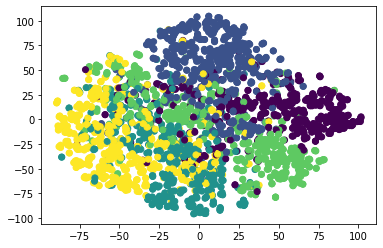

In [ ]:
from sklearn.manifold import TSNE
f_tsne = TSNE(n_components=2,learning_rate='auto', init='random', perplexity=3).fit_transform(f_all)
plt.scatter(*f_tsne.T, c=y_all)

In [ ]:
# Q23
# t-SNE measures similarity between pairs of points in both high dimension and low dimension
# and then try to use the set of similarity measured in low dimension to reflect the set of
# similarity measured in high dimension as good as possible. As we can see, with t-SNE the data
# points with different ground truth labels are well separated, while with PCA, data points 
# with different labels are squeezed together and overlapping with each other. This happens 
# because the high dimensional similarity is not well represented in one dimension with PCA,
# while with t-SNE, high dimensional similarity is reflected in a low dimension pretty well by 
# minimizing the KL divergence.   

In [ ]:
#Q24

In [1]:
%pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 69.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp38-cp38-linux_x86_64.whl size=3773972 sha256=fe12982508bd3f8fdc6a64088cdb01c5e68ceef79810f21e384f503cb6a3d21e
  Stored in directory: /root/.cache/pip/wheels/76/06/48/527e038689c581cc9e519c73840efdc7473805149e55bd7ffd
Successfully built hdbscan


In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    def get_param(self):
        return self.n_components
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [2]:
%pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=3f4e75f638ac665584f3883796d39294c007e4f73406e92f7c1e58f0d1a0bddd
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=de36b31f03afe5a4ed61353583155bf347fdf9f99e3af474fa87129a8bbb53eb
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
import umap
train_X, test_X, train_Y, test_Y = train_test_split(f_all,y_all,test_size=0.2)
## SVD
svd=TruncatedSVD(n_components=50)
X_SVD=svd.fit_transform(f_all)
## UMAP
umap_reducer=umap.UMAP(n_components=50)
X_UMAP=umap_reducer.fit_transform(f_all)
##autoEncoder
autoencoder=Autoencoder(50)
X_AE=autoencoder.fit_transform(f_all)
# clusters
kmeans=KMeans(n_clusters=5)
aggloClus=AgglomerativeClustering(n_clusters=5)
hdbscanCluster=hdbscan.HDBSCAN()

NameError: ignored

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
def printRandScore(prediction,y):
    print(adjusted_rand_score(y,prediction))

In [ ]:
#kmeans 
#no reduce
predict_no_reduce=kmeans.fit_predict(f_all)
#svd
predict_svd=kmeans.fit_predict(X_SVD)
#umap
predict_umap=kmeans.fit_predict(X_UMAP)
#autoencoder
predict_ae=kmeans.fit_predict(X_AE)
print('kmeans with no reduction rand_score: ')
printRandScore(predict_no_reduce,y_all)
print('kmeans with svd rand_score: ')
printRandScore(predict_svd,y_all)
print('kmeans with umap rand_score: ')
printRandScore(predict_umap,y_all)
print('kmeans with Autoencoder rand_score: ')
printRandScore(predict_ae,y_all)

In [ ]:
#agglomerative clustering 
#no reduce
predict_no_reduce_agg=aggloClus.fit_predict(f_all)
#svd
predict_svd_agg=aggloClus.fit_predict(X_SVD)
#umap
predict_umap_agg=aggloClus.fit_predict(X_UMAP)
#autoencoder
predict_ae_agg=aggloClus.fit_predict(X_AE)

print('agglomerative clustering with no reduction rand_score: ')
printRandScore(predict_no_reduce_agg,y_all)
print('agglomerative clustering with svd rand_score: ')
printRandScore(predict_svd_agg,y_all)
print('agglomerative clustering with umap rand_score: ')
printRandScore(predict_umap_agg,y_all)
print('agglomerative clustering with Autoencoder rand_score: ')
printRandScore(predict_ae_agg,y_all)

agglomerative clustering with no reduction rand_score: 
0.6862000871875192
agglomerative clustering with svd rand_score: 
0.73863528510096
agglomerative clustering with umap rand_score: 
0.7780505791583211
agglomerative clustering with Autoencoder rand_score: 
0.7221053038084013


In [ ]:
from tempfile import mkdtemp
from sklearn.model_selection import GridSearchCV

cachedir = mkdtemp()
pipe = Pipeline(steps=[
                       ('Reduction', None), 
                       ('cluster', None)], memory=cachedir)
min_samples=[2,50,100,200]
min_cluster_size=[2,50,100,200]
param = {
    'Reduction': [TruncatedSVD(n_components=50),
                  umap.UMAP(n_components = 50)
                 ],
    'cluster': [AgglomerativeClustering(n_clusters=5)]
    }
  

In [ ]:
m1=AgglomerativeClustering(n_clusters=5)

In [ ]:
m1.fit(train_X,train_Y)

AgglomerativeClustering(n_clusters=5)

In [ ]:
m1.labels_

array([0, 1, 0, ..., 2, 2, 2])

In [ ]:
def getScore(model,X,Y):
    model.fit(X)
    print(model.labels_)
    return adjusted_rand_score(Y,model.labels_)


In [ ]:
from tempfile import mkdtemp
from sklearn.model_selection import GridSearchCV

cachedir = mkdtemp()
min_samples=[5,10,20,50]
min_cluster_size=[200]
pipe=Pipeline(steps=[('cluster', hdbscanCluster)], memory=cachedir)
param={
    'cluster__min_samples':min_samples,
    'cluster__min_cluster_size':min_cluster_size
    }

In [ ]:
param_dict={}
Xs=[f_all,X_SVD,X_UMAP,X_AE]
reducers=['No reducer','SVD','UMAP','Autoencoder']
for min_sam in min_samples:
    for min_clus in min_cluster_size:
        for i in range(len(Xs)):
            X=Xs[i]
            hdbscanCluster=hdbscan.HDBSCAN(min_samples=min_sam,min_cluster_size=min_clus)
            hdbscanCluster.fit(X)
            score=adjusted_rand_score(y_all,hdbscanCluster.labels_)
            print('min_samples {}, min_cluster_size {}, with reducer {} has a rand_score:{}'.format(min_sam,min_clus,reducers[i],score))
            param_dict[(min_sam,min_clus,reducers[i])]=score

In [ ]:
cv = [(slice(None), slice(None))]
grid = GridSearchCV(pipe, n_jobs=5, param_grid=param,scoring=getScore,cv=cv,error_score='raise')


In [ ]:
grid.fit(f_all,y_all)

AttributeError: ignored

In [ ]:

grid.cv_results_

{'mean_fit_time': array([288.19199324, 289.93539572, 289.00557399, 289.56542182]),
 'std_fit_time': array([0., 0., 0., 0.]),
 'mean_score_time': array([308.11511779, 306.34289932, 307.05245781, 305.72146368]),
 'std_score_time': array([0., 0., 0., 0.]),
 'param_cluster__min_cluster_size': masked_array(data=[200, 200, 200, 200],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_cluster__min_samples': masked_array(data=[5, 10, 20, 50],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'cluster__min_cluster_size': 200, 'cluster__min_samples': 5},
  {'cluster__min_cluster_size': 200, 'cluster__min_samples': 10},
  {'cluster__min_cluster_size': 200, 'cluster__min_samples': 20},
  {'cluster__min_cluster_size': 200, 'cluster__min_samples': 50}],
 'split0_test_score': array([0., 0., 0., 0.]),
 'mean_test_score': array([0., 0., 0., 0.]),
 'std_test_score': array([0., 0., 0.

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print(len(y_all))

3670


In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################
                X_ = X_.cuda()
                output=self(X_)
                loss=criterion(output,y_)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        return self
    
    def eval(self, X_test, y_test):
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        output=self(X_test)
        predicted=[]
        for i in output:
            predicted.append(torch.argmax(i).item())
        return accuracy_score(predicted,y_test)

In [ ]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(f_all,y_all,test_size=0.2)

In [ ]:
import torch
mlp=MLP(4096)
mlp=mlp.train(train_X,train_Y)


100%|██████████| 100/100 [00:09<00:00, 10.17it/s]


In [ ]:
mlp.eval(test_X,test_Y)


0.9114441416893733

In [ ]:

f_all_reduce=Autoencoder(50).fit_transform(f_all)
train_RX, test_RX, train_RY, test_RY = train_test_split(f_all_reduce,y_all,test_size=0.2)
mlp_reduce=MLP(50)
mlp_reduce=mlp_reduce.train(train_RX,train_RY)

100%|██████████| 100/100 [00:07<00:00, 12.79it/s]


In [ ]:
mlp_reduce.eval(test_RX,test_RY)

0.8896457765667575

In [ ]:
#Q25
#test accuracy with MLP classifer on original VGG features is 0.9114441416893733
#test accuracy with MLP classifer on reduced-dimension VGG features is 0.8896457765667575
#the performance drom from 0.911 to 0.890. The performance drop is not that significant
#This indicates that reducing dimension using autoencoder well reflect the original features 


# Here

In [ ]:
#Q19
#We can use VGG network that's trained a dataset with different classes as targets because we can transfer the learning from the pretrained dataset to the
#custom dataset and fit on the custom dataset on a higher layer. That is why we can use a pretrained VGG model to have discriminative power for a custom dataset
 

In [ ]:
#Q20
#load data in batch and extract features from input image
#extract features from the pretrained VGG model. Perform average pooling on the input image of pretrained VGG model to downsample input features
#flatten features that are downsampled through pooling to map features of the image into one-dimensional features.


In [5]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


In [6]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
            print('features',vgg.features)
            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        print(x.shape)
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

In [ ]:
#Q21
#shape of a batch of extracted features is (64, 4096), which indicates that for each image,
# 4096 features are extracted
#shape of a batch of images is ([64, 3, 224, 224]) which means there are 64 images in a batch with 
# 3 color channel, and each image has 224 pixels in height and 224 pixels in width. Therefore,
# there are 224*224=50176 pixels per image in the original image

In [ ]:
f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
for x, y in tqdm(dataloader):
    print('shape of original image',x.shape)
    with torch.no_grad():
        f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
        print('shape of extracted feature',f_all.shape)
        y_all = np.concatenate([y_all, y])

  0%|          | 0/58 [00:00<?, ?it/s]

shape of original image torch.Size([64, 3, 224, 224])


  0%|          | 0/58 [00:05<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
#Q22
#The extracted features are pretty dense with most of the entries non-zero compared with 
#sparse TF-IDF where most entries are 0 


In [ ]:
for i in f_all[1]:
    print(i)

-1.7973332405090332
-0.12832233309745789
-0.062017083168029785
-7.213447093963623
-10.11540412902832
0.5523401498794556
0.6544758677482605
-5.725966930389404
2.370662212371826
2.8813982009887695
-1.1413565874099731
5.932681560516357
-1.8873517513275146
2.696450710296631
-4.824006080627441
-6.690793991088867
-0.4619252681732178
-0.9837530255317688
-3.128567934036255
-3.0161404609680176
-0.5680132508277893
0.7286487817764282
-3.810023307800293
-5.024564266204834
-3.0833792686462402
4.9379730224609375
-1.9882713556289673
-0.27535706758499146
0.19966930150985718
2.2975997924804688
0.3811684846878052
-1.8097423315048218
-7.594351291656494
0.025639772415161133
-0.7846118807792664
-3.038848876953125
2.93279767036438
-3.6505026817321777
-5.908799648284912
1.3514974117279053
1.9305050373077393
-3.3864378929138184
-0.9111111164093018
-5.477395057678223
-0.12294763326644897
1.0849453210830688
2.2258622646331787
-2.6350014209747314
-6.921241760253906
-1.789435625076294
-5.367063522338867
-0.563330

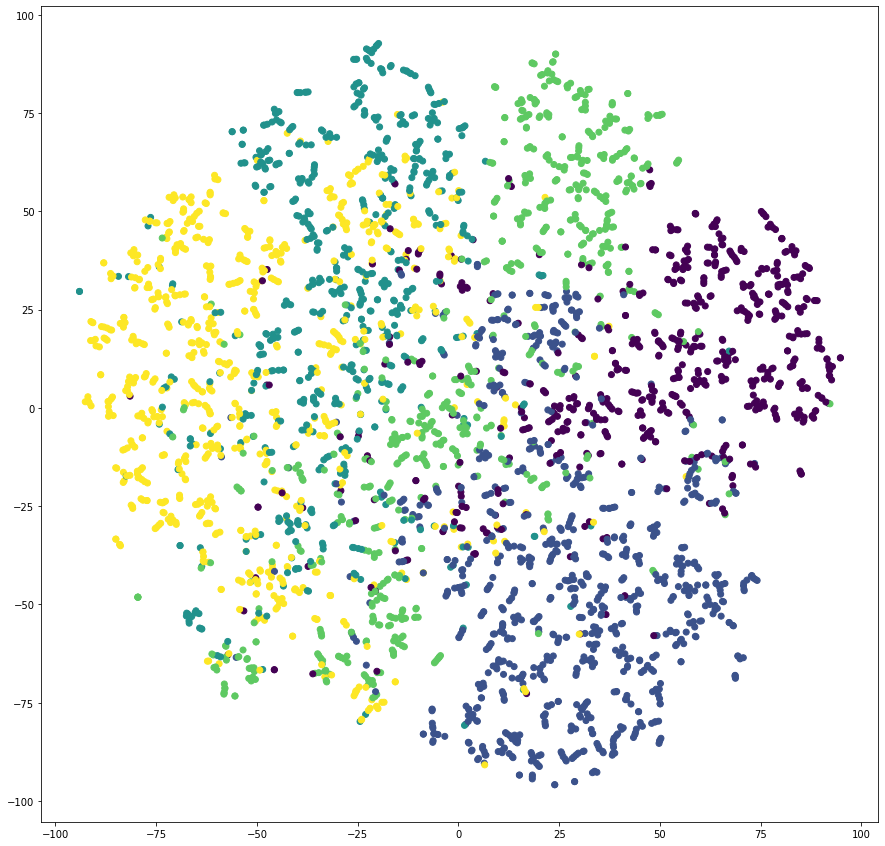

In [4]:
from sklearn.manifold import TSNE
plt.figure(figsize=(15,15))
f_tsne = TSNE(n_components=2,learning_rate='auto', init='random', perplexity=3).fit_transform(f_all)
plt.scatter(*f_tsne.T, c=y_all)

In [ ]:
# Q23
# t-SNE measures similarity between pairs of points in both high dimension and low dimension
# and then try to use the set of similarity measured in low dimension to reflect the set of
# similarity measured in high dimension as good as possible. As we can see, with t-SNE the data
# points with different ground truth labels are well separated, while with PCA, data points 
# with different labels are squeezed together and overlapping with each other. This happens 
# because the high dimensional similarity is not well represented in one dimension with PCA,
# while with t-SNE, high dimensional similarity is reflected in a low dimension pretty well by 
# minimizing the KL divergence.   

In [ ]:
#Q24
#Best result is given by KMeans with k=5 with UMAP with n_components=50

In [7]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    def get_param(self):
        return self.n_components
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [13]:
from sklearn.model_selection import train_test_split
import umap
train_X, test_X, train_Y, test_Y = train_test_split(f_all,y_all,test_size=0.2)
## SVD
svd=TruncatedSVD(n_components=50)
X_SVD=svd.fit_transform(f_all)
## UMAP
umap_reducer=umap.UMAP(n_components=50)
X_UMAP=umap_reducer.fit_transform(f_all)
##autoEncoder
autoencoder=Autoencoder(50)
X_AE=autoencoder.fit_transform(f_all)
# clusters
kmeans=KMeans(n_clusters=5)
aggloClus=AgglomerativeClustering(n_clusters=5)
hdbscanCluster=hdbscan.HDBSCAN()

100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


In [14]:
from sklearn.metrics.cluster import adjusted_rand_score
def printRandScore(prediction,y):
    print(adjusted_rand_score(y,prediction))

In [ ]:
#kmeans 
#no reduce
predict_no_reduce=KMeans(n_clusters=5).fit_predict(f_all)
#svd
predict_svd=KMeans(n_clusters=5).fit_predict(X_SVD)
#umap
predict_umap=KMeans(n_clusters=5).fit_predict(X_UMAP)
#autoencoder
predict_ae=KMeans(n_clusters=5).fit_predict(X_AE)
print('kmeans with no reduction rand_score: ')
printRandScore(predict_no_reduce,y_all)
print('kmeans with svd rand_score: ')
printRandScore(predict_svd,y_all)
print('kmeans with umap rand_score: ')
printRandScore(predict_umap,y_all)
print('kmeans with Autoencoder rand_score: ')
printRandScore(predict_ae,y_all)

kmeans with no reduction rand_score: 
0.18787470770763892
kmeans with svd rand_score: 
0.19466133319184695
kmeans with umap rand_score: 
0.39505465618751134
kmeans with Autoencoder rand_score: 
0.18183722571447192


In [ ]:
#agglomerative clustering 
#no reduce
predict_no_reduce_agg=AgglomerativeClustering(n_clusters=5,linkage='ward').fit_predict(f_all)
#svd
predict_svd_agg=AgglomerativeClustering(n_clusters=5,linkage='ward').fit_predict(X_SVD)
#umap
predict_umap_agg=AgglomerativeClustering(n_clusters=5,linkage='ward').fit_predict(X_UMAP)
#autoencoder
predict_ae_agg=AgglomerativeClustering(n_clusters=5,linkage='ward').fit_predict(X_AE)

print('agglomerative clustering with no reduction rand_score: ')
printRandScore(predict_no_reduce_agg,y_all)
print('agglomerative clustering with svd rand_score: ')
printRandScore(predict_svd_agg,y_all)
print('agglomerative clustering with umap rand_score: ')
printRandScore(predict_umap_agg,y_all)
print('agglomerative clustering with Autoencoder rand_score: ')
printRandScore(predict_ae_agg,y_all)

agglomerative clustering with no reduction rand_score: 
0.18855278251971858
agglomerative clustering with svd rand_score: 
0.2022280574714916
agglomerative clustering with umap rand_score: 
0.3807640175413126
agglomerative clustering with Autoencoder rand_score: 
0.3051429354565339


In [32]:
#HDBSCAN
#no reduce
min_samples=[1,5,10,50]
min_cluster_size=[50,100,200]
for min_clus in min_cluster_size:
    for min_sam in min_samples:
        predict_no_reduce_hdb=hdbscan.HDBSCAN(min_samples=min_sam,min_cluster_size=min_clus).fit_predict(f_all)
        #svd
        predict_svd_hdb=hdbscan.HDBSCAN(min_samples=min_sam,min_cluster_size=min_clus).fit_predict(X_SVD)
        #umap
        predict_umap_hdb=hdbscan.HDBSCAN(min_samples=min_sam,min_cluster_size=min_clus).fit_predict(X_UMAP)
        #autoencoder
        predict_ae_hdb=hdbscan.HDBSCAN(min_samples=min_sam,min_cluster_size=min_clus).fit_predict(X_AE)
        print('HDBSCAN with min_cluster_size of {} and min_samples of {} with no reduction rand_score: '.format(min_clus,min_sam))
        printRandScore(predict_no_reduce_hdb,y_all)
        print('HDBSCAN with min_cluster_size of {} and min_samples of {} with svd rand_score: '.format(min_clus,min_sam))
        printRandScore(predict_svd_hdb,y_all)
        print('HDBSCAN with min_cluster_size of {} and min_samples of {} with umap rand_score: '.format(min_clus,min_sam))
        printRandScore(predict_umap_hdb,y_all)
        print('HDBSCAN with min_cluster_size of {} and min_samples of {} with Autoencoder rand_score: '.format(min_clus,min_sam))
        printRandScore(predict_ae_hdb,y_all)


HDBSCAN with min_cluster_size of 50 and min_samples of 1 with no reduction rand_score: 
0.0
HDBSCAN with min_cluster_size of 50 and min_samples of 1 with svd rand_score: 
0.0
HDBSCAN with min_cluster_size of 50 and min_samples of 1 with umap rand_score: 
0.23363400090555445
HDBSCAN with min_cluster_size of 50 and min_samples of 1 with Autoencoder rand_score: 
0.0
HDBSCAN with min_cluster_size of 50 and min_samples of 5 with no reduction rand_score: 
0.0
HDBSCAN with min_cluster_size of 50 and min_samples of 5 with svd rand_score: 
0.0
HDBSCAN with min_cluster_size of 50 and min_samples of 5 with umap rand_score: 
0.22062759018168018
HDBSCAN with min_cluster_size of 50 and min_samples of 5 with Autoencoder rand_score: 
0.0
HDBSCAN with min_cluster_size of 50 and min_samples of 10 with no reduction rand_score: 
0.0
HDBSCAN with min_cluster_size of 50 and min_samples of 10 with svd rand_score: 
0.0
HDBSCAN with min_cluster_size of 50 and min_samples of 10 with umap rand_score: 
0.34006615

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print(len(y_all))

3670


In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################
                X_ = X_.cuda()
                output=self(X_)
                loss=criterion(output,y_)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        return self
    
    def eval(self, X_test, y_test):
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        output=self(X_test)
        predicted=[]
        for i in output:
            predicted.append(torch.argmax(i).item())
        return accuracy_score(predicted,y_test)

In [ ]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(f_all,y_all,test_size=0.2)

In [ ]:
import torch
mlp=MLP(4096)
mlp=mlp.train(train_X,train_Y)


100%|██████████| 100/100 [00:09<00:00, 10.17it/s]


In [ ]:
mlp.eval(test_X,test_Y)


0.9114441416893733

In [ ]:

f_all_reduce=Autoencoder(50).fit_transform(f_all)
train_RX, test_RX, train_RY, test_RY = train_test_split(f_all_reduce,y_all,test_size=0.2)
mlp_reduce=MLP(50)
mlp_reduce=mlp_reduce.train(train_RX,train_RY)

100%|██████████| 100/100 [00:07<00:00, 12.79it/s]


In [ ]:
mlp_reduce.eval(test_RX,test_RY)

0.8896457765667575

In [33]:
#Q25
#test accuracy with MLP classifer on original VGG features is 0.9114441416893733
#test accuracy with MLP classifer on reduced-dimension VGG features is 0.8896457765667575
#the performance drom from 0.911 to 0.890. The performance drop is not that significant
#This indicates that reducing dimension using autoencoder well reflect the original features 
#The success in classification makes sense in the context of clustering result because
#in this task, we are given label and we train the classifer to learn from data, and classifier
#we better learn about the data. However, clustering algorithm learn data without given labels.
#Thus, it doesn't perform as good as classifer.
